## Common Functions

### Load data and split

In [38]:
# data split, copied from Sev's experiment ipynb
import pandas as pd

txs_classes = pd.read_csv('../data/elliptic_txs_classes.csv')
txs_edges = pd.read_csv('../data/elliptic_txs_edgelist.csv')
txs_features = pd.read_csv('../data/elliptic_txs_features.csv', header=None)


# join features with classes using tx id (1st column of txs_features)
txs_data = txs_features.merge(txs_classes, left_on=0, right_on='txId', how='left')

# convert class labels to integers
# 1: licit (0), 2: illicit (1), unknown: -1
label_mapping = {'1': 0, '2': 1, 'unknown': -1}
txs_data['class'] = txs_data['class'].map(label_mapping).astype(int)

# split data and edges into train and test according to timestep (2nd column of txs_features)
train_data_all = txs_data[txs_data[1] <= 34]
test_data_all = txs_data[txs_data[1] > 34]

# separate datasets with labels(1 or 2) from those without labels(class=unknown)
train_data_labeled = train_data_all[train_data_all['class'].isin([0, 1])]
test_data_labeled = test_data_all[test_data_all['class'].isin([0, 1])]

# process edges like data: add timestep info and split into train and test
txs_edges = txs_edges.merge(txs_features[[0, 1]], left_on='txId1', right_on=0, how='left').rename(columns={1: 'timestep'}).drop(columns=[0])
train_edges_all = txs_edges[txs_edges['timestep'] <= 34]
test_edges_all = txs_edges[txs_edges['timestep'] > 34]
train_edges_labeled = train_edges_all[train_edges_all['txId1'].isin(train_data_labeled['txId']) & train_edges_all['txId2'].isin(train_data_labeled['txId'])]
test_edges_labeled = test_edges_all[test_edges_all['txId1'].isin(test_data_labeled['txId']) & test_edges_all['txId2'].isin(test_data_labeled['txId'])]

# print sizes of datasets
print(f"Train data all: {train_data_all.shape}, Train data labeled: {train_data_labeled.shape}")
print(f"Test data all: {test_data_all.shape}, Test data labeled: {test_data_labeled.shape}")
print(f"Train edges all: {train_edges_all.shape}, Train edges labeled: {train_edges_labeled.shape}")
print(f"Test edges all: {test_edges_all.shape}, Test edges labeled: {test_edges_labeled.shape}")


Train data all: (136265, 169), Train data labeled: (29894, 169)
Test data all: (67504, 169), Test data labeled: (16670, 169)
Train edges all: (156843, 3), Train edges labeled: (22898, 3)
Test edges all: (77512, 3), Test edges labeled: (13726, 3)
Test data labeled grouped by timestep: [(35, 1341), (36, 1708), (37, 498), (38, 756), (39, 1183), (40, 1211), (41, 1132), (42, 2154), (43, 1370), (44, 1591), (45, 1221), (46, 712), (47, 846), (48, 471), (49, 476)]


In [42]:

# test data group dict, group by timestep for evaluation on each timestep
test_data_labeled_timestep = {}
test_edges_labeled_timestep = {}
for t in range(35, 50):
    test_data_labeled_timestep[t] = test_data_labeled[test_data_labeled[1] == t]
    test_edges_labeled_timestep[t] = test_edges_labeled[test_edges_labeled['timestep'] == t]
print(f"Test data labeled grouped by timestep: {[ (t, df.shape[0]) for t, df in test_data_labeled_timestep.items() ]}")
print(f"Test edges labeled grouped by timestep: {[ (t, df.shape[0]) for t, df in test_edges_labeled_timestep.items() ]}")

Test data labeled grouped by timestep: [(35, 1341), (36, 1708), (37, 498), (38, 756), (39, 1183), (40, 1211), (41, 1132), (42, 2154), (43, 1370), (44, 1591), (45, 1221), (46, 712), (47, 846), (48, 471), (49, 476)]
Test edges labeled grouped by timestep: [(35, 1002), (36, 1148), (37, 423), (38, 653), (39, 1055), (40, 1180), (41, 1048), (42, 1443), (43, 935), (44, 1497), (45, 1346), (46, 388), (47, 822), (48, 371), (49, 415)]


### Create DGL graph

In [36]:
# create DGL graphs - copied from Sev's experiment ipynb
import dgl
import torch

# create DGL graphs for train and test data
def create_dgl_graph(data, edges, features="all"):
    # features: all or local
    # all: all features except txId, timestep, class; 
    # local: only local features (first 94 features except timestep) (column 2 to 95)
    node_ids = data['txId'].tolist()
    id_to_idx = {node_id: idx for idx, node_id in enumerate(node_ids)}
    
    src = edges['txId1'].map(id_to_idx).tolist()
    dst = edges['txId2'].map(id_to_idx).tolist()
    
    g = dgl.graph((src, dst), num_nodes=len(node_ids))
    if features == "local": # local features
        features = torch.tensor(data.iloc[:, 2: 96].values, dtype=torch.float32)
    else: # all features include local + one hop features
        features = torch.tensor(data.iloc[:, 2:-2].values, dtype=torch.float32)
    labels = torch.tensor(data['class'].values, dtype=torch.long)
    
    g.ndata['feat'] = features
    g.ndata['label'] = labels
    
    return g

# graph with all features
train_labeled_graph = create_dgl_graph(train_data_labeled, train_edges_labeled)
test_labeled_graph = create_dgl_graph(test_data_labeled, test_edges_labeled)
train_all_graph = create_dgl_graph(train_data_all, train_edges_all)
test_all_graph = create_dgl_graph(test_data_all, test_edges_all)

print(f"Train labeled graph: {train_labeled_graph}")
print(f"Test labeled graph: {test_labeled_graph}")
print(f"Train all graph: {train_all_graph}")
print(f"Test all graph: {test_all_graph}")


# graph with local features only
train_labeled_graph_local = create_dgl_graph(train_data_labeled, train_edges_labeled, features="local")
test_labeled_graph_local = create_dgl_graph(test_data_labeled, test_edges_labeled, features="local")
train_all_graph_local = create_dgl_graph(train_data_all, train_edges_all, features="local")
test_all_graph_local = create_dgl_graph(test_data_all, test_edges_all, features="local")

print(f"Train labeled graph local features: {train_labeled_graph_local}")
print(f"Test labeled graph local features: {test_labeled_graph_local}")
print(f"Train all graph local features: {train_all_graph_local}")
print(f"Test all graph local features: {test_all_graph_local}")

Train labeled graph: Graph(num_nodes=29894, num_edges=22898,
      ndata_schemes={'feat': Scheme(shape=(165,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={})
Test labeled graph: Graph(num_nodes=16670, num_edges=13726,
      ndata_schemes={'feat': Scheme(shape=(165,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={})
Train all graph: Graph(num_nodes=136265, num_edges=156843,
      ndata_schemes={'feat': Scheme(shape=(165,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={})
Test all graph: Graph(num_nodes=67504, num_edges=77512,
      ndata_schemes={'feat': Scheme(shape=(165,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={})
Train labeled graph local features: Graph(num_nodes=29894, num_edges=22898,
      ndata_schemes={'feat': Scheme(shape=(94,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64)}
   

In [75]:
# time steped testing graphs
test_labeled_graphs_timestep = {}
for t in range(35, 50):
    data_t = test_data_labeled_timestep[t]
    edges_t = test_edges_labeled_timestep[t]
    test_labeled_graphs_timestep[t] = create_dgl_graph(data_t, edges_t)

# test stepped testing graphs local features
test_labeled_graphs_timestep_local = {}
for t in range(35, 50):
    data_t = test_data_labeled_timestep[t]
    edges_t = test_edges_labeled_timestep[t]
    test_labeled_graphs_timestep_local[t] = create_dgl_graph(data_t, edges_t, features="local")

In [70]:
# Prepare_training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

labeled_only = True

if labeled_only:
    train_graph = dgl.to_bidirected(train_labeled_graph, copy_ndata=True)
    test_graph = dgl.to_bidirected(test_labeled_graph, copy_ndata=True)
else:
    train_graph = dgl.to_bidirected(train_all_graph, copy_ndata=True)
    test_graph = dgl.to_bidirected(test_all_graph, copy_ndata=True)

# --- Check Train Graph ---
train_degrees = train_graph.in_degrees()
train_isolated_nodes = (train_degrees == 0).sum().item()
train_total_nodes = train_graph.num_nodes()
train_percent_isolated = (train_isolated_nodes / train_total_nodes) * 100

print(f"--- Training Graph ---")
print(f"Total nodes: {train_total_nodes}")
print(f"Isolated nodes: {train_isolated_nodes}")
print(f"Percentage isolated: {train_percent_isolated:.2f}%")
print(f"------------------------")


# --- Check Test Graph ---
test_degrees = test_graph.in_degrees()
test_isolated_nodes = (test_degrees == 0).sum().item()
test_total_nodes = test_graph.num_nodes()
test_percent_isolated = (test_isolated_nodes / test_total_nodes) * 100

print(f"--- Test Graph ---")
print(f"Total nodes: {test_total_nodes}")
print(f"Isolated nodes: {test_isolated_nodes}")
print(f"Percentage isolated: {test_percent_isolated:.2f}%")
print(f"----------------------")

train_graph = dgl.add_self_loop(train_graph)
test_graph = dgl.add_self_loop(test_graph)

train_features = train_graph.ndata['feat']
train_labels = train_graph.ndata['label']
train_mask = (train_labels >= 0)
test_features = test_graph.ndata['feat']
test_labels = test_graph.ndata['label']
test_mask = (test_labels >= 0)

train_graph = train_graph.to(device)
test_graph = test_graph.to(device)
train_features = train_features.to(device)
train_labels = train_labels.to(device)
test_features = test_features.to(device)
test_labels = test_labels.to(device)


--- Training Graph ---
Total nodes: 29894
Isolated nodes: 6415
Percentage isolated: 21.46%
------------------------
--- Test Graph ---
Total nodes: 16670
Isolated nodes: 4275
Percentage isolated: 25.64%
----------------------


In [80]:
# Prepare_training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def prepare_train_graphs(labeled_only=True, local_feature=False):
    print(f"============= Preparing graphs: labeled_only={labeled_only}, local_feature={local_feature} =================")
    if labeled_only:
        if local_feature:
            train_graph = dgl.to_bidirected(train_labeled_graph_local, copy_ndata=True)
            test_graph = dgl.to_bidirected(test_labeled_graph_local, copy_ndata=True)
        else:
            train_graph = dgl.to_bidirected(train_labeled_graph, copy_ndata=True)
            test_graph = dgl.to_bidirected(test_labeled_graph, copy_ndata=True)
    else:
        if local_feature:
            train_graph = dgl.to_bidirected(train_all_graph_local, copy_ndata=True)
            test_graph = dgl.to_bidirected(test_all_graph_local, copy_ndata=True)
        else:
            train_graph = dgl.to_bidirected(train_all_graph, copy_ndata=True)
            test_graph = dgl.to_bidirected(test_all_graph, copy_ndata=True)

    # --- Check Train Graph ---
    train_degrees = train_graph.in_degrees()
    train_isolated_nodes = (train_degrees == 0).sum().item()
    train_total_nodes = train_graph.num_nodes()
    train_percent_isolated = (train_isolated_nodes / train_total_nodes) * 100

    print(f"Training Graph: Percentage isolated: {train_percent_isolated:.2f}%; Isolated nodes: {train_isolated_nodes}; Total nodes: {train_total_nodes}")

    # --- Check Test Graph ---
    test_degrees = test_graph.in_degrees()
    test_isolated_nodes = (test_degrees == 0).sum().item()
    test_total_nodes = test_graph.num_nodes()
    test_percent_isolated = (test_isolated_nodes / test_total_nodes) * 100

    print(f"Test Graph: Percentage isolated: {test_percent_isolated:.2f}%; Total nodes: {test_total_nodes}; Isolated nodes: {test_isolated_nodes}\n")

    train_graph = dgl.add_self_loop(train_graph)
    test_graph = dgl.add_self_loop(test_graph)

    train_features = train_graph.ndata['feat']
    train_labels = train_graph.ndata['label']
    train_mask = (train_labels >= 0)
    test_features = test_graph.ndata['feat']
    test_labels = test_graph.ndata['label']
    test_mask = (test_labels >= 0)

    train_graph = train_graph.to(device)
    test_graph = test_graph.to(device)
    train_features = train_features.to(device)
    train_labels = train_labels.to(device)
    test_features = test_features.to(device)
    test_labels = test_labels.to(device)

    return train_graph, train_features, train_labels, train_mask, test_graph, test_features, test_labels, test_mask

train_graph_labeled, train_feature_labeled, train_labels_labeled, train_mask_labeled, \
    test_graph_labeled, test_features_labeled, test_labels_labeled, test_mask_labeled \
        = prepare_train_graphs(labeled_only=True, local_feature=False)

train_graph_all, train_feature_all, train_labels_all, train_mask_all, \
    test_graph_all, test_features_all, test_labels_all, test_mask_all \
        = prepare_train_graphs(labeled_only=False, local_feature=False)

train_graph_labeled_local, train_feature_labeled_local, train_labels_labeled_local, train_mask_labeled_local, \
    test_graph_labeled_local, test_features_labeled_local, test_labels_labeled_local, test_mask_labeled_local \
        = prepare_train_graphs(labeled_only=True, local_feature=True)

train_graph_all_local, train_feature_all_local, train_labels_all_local, train_mask_all_local, \
    test_graph_all_local, test_features_all_local, test_labels_all_local, test_mask_all_local \
        = prepare_train_graphs(labeled_only=False, local_feature=True)


============= Preparing graphs: labeled_only=True, local_feature=False =================
Training Graph: Percentage isolated: 21.46%; Isolated nodes: 6415; Total nodes: 29894
Test Graph: Percentage isolated: 25.64%; Total nodes: 16670; Isolated nodes: 4275

============= Preparing graphs: labeled_only=False, local_feature=False =================
Training Graph: Percentage isolated: 0.00%; Isolated nodes: 0; Total nodes: 136265
Test Graph: Percentage isolated: 0.00%; Total nodes: 67504; Isolated nodes: 0

============= Preparing graphs: labeled_only=True, local_feature=True =================
Training Graph: Percentage isolated: 21.46%; Isolated nodes: 6415; Total nodes: 29894
Test Graph: Percentage isolated: 25.64%; Total nodes: 16670; Isolated nodes: 4275

============= Preparing graphs: labeled_only=False, local_feature=True =================
Training Graph: Percentage isolated: 0.00%; Isolated nodes: 0; Total nodes: 136265
Test Graph: Percentage isolated: 0.00%; Total nodes: 67504; I

### Training function

In [104]:
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
import torch.nn as nn
import torch
import matplotlib.pyplot as plt

def evaluate_model(model, test_graph, test_features, test_labels, test_mask, criterion):
    model.eval()
    with torch.no_grad():
        test_logits = model(test_graph, test_features)
        test_preds = test_logits.argmax(dim=1)
        test_loss = criterion(test_logits, test_labels).item()
        
        # Get masked predictions and labels
        masked_preds = test_preds[test_mask].cpu().numpy()
        masked_labels = test_labels[test_mask].cpu().numpy()
        
        # Use sklearn's precision_recall_fscore_support with zero_division handling
        # pos_label=0 for illicit class, average=None to get per-class metrics
        precision, recall, f1, support = precision_recall_fscore_support(
            masked_labels, masked_preds, 
            labels=[0, 1],  # illicit=0, licit=1
            average=None,
            zero_division=0.0
        )
        
        # Extract illicit (class 0) metrics
        test_precision = precision[0] if len(precision) > 0 else 0.0
        test_recall = recall[0] if len(recall) > 0 else 0.0
        test_f1 = f1[0] if len(f1) > 0 else 0.0
        
        test_report = classification_report(
            masked_labels, masked_preds, 
            target_names=['illicit', 'licit'],
            zero_division=0
        )
        
        return test_loss, test_precision, test_recall, test_f1, test_report

def plot_training_history(history, model_name):

    # --- Create X-Axes ---
    
    # 1. X-axis for 'train_loss' (1 point per epoch)
    # We add a small offset (0.5) to starting_epoch for clearer plotting
    # if we resume training, so the first point isn't hidden.
    starting_epoch = history.get('test_epochs', [1])[0] - 1
    total_train_epochs = len(history.get('train_loss', []))
    train_loss_epochs = list(range(starting_epoch + 1, starting_epoch + 1 + total_train_epochs))

    # 2. X-axis for all test/validation metrics (sparse)
    # This list is saved directly in our history object
    eval_epochs = history.get('test_epochs', [])

    plt.figure(figsize=(15, 6))

    # --- Plot 1: Loss (Train vs. Test) ---
    plt.subplot(1, 2, 1)
    
    # Plot Train Loss (dense)
    if train_loss_epochs:
        plt.plot(train_loss_epochs, history['train_loss'], label='Train Loss', alpha=0.7, zorder=1)
    
    # Plot Test Loss (sparse)
    if eval_epochs:
        plt.plot(eval_epochs, history['test_loss'], label='Test Loss', 
                 marker='o', linestyle='--', linewidth=2, markersize=5, zorder=2)
        
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{model_name} Loss over Epochs')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)

    # --- Plot 2: F1 Score (Train vs. Test) ---
    plt.subplot(1, 2, 2)
    
    # Plot Train F1 (sparse, from eval steps)
    if eval_epochs and 'train_f1' in history:
        plt.plot(eval_epochs, history['train_f1'], label='Train F1 Score', 
                 marker='s', linestyle=':', linewidth=2, markersize=5)
    
    # Plot Test F1 (sparse, from eval steps)
    if eval_epochs and 'test_f1' in history:
        plt.plot(eval_epochs, history['test_f1'], label='Test F1 Score', 
                 color='orange', marker='o', linestyle='--', linewidth=2, markersize=5)
        
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.title(f'{model_name} F1 Score at Evaluation Steps')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

def train_model(model, model_name, optimizer, criterion, train_graph, train_features, train_labels, train_mask,
                test_graph, test_features, test_labels, test_mask,
                num_epochs, test_every=100, previous_history=None, print_best_report=True, show_plots=False):
    # if previous_history is provided, resume training from there
    if previous_history is not None:
        history = previous_history
        starting_epoch = len(history["train_loss"]) + 1
    else:
        history = {"train_loss": [], "train_f1": [], "train_precision": [], "train_recall": [],
               "test_loss": [], "test_f1": [], "test_precision": [], "test_recall": [],
               "test_epochs": [],
               "best_test_f1": 0.0, "best_report": None, "best_model_state": None, "best_epoch": -1, 
               "last_test_f1": 0.0, "last_report": None, "latest_model_state": None}
        starting_epoch = 1

    final_epoch_of_training = starting_epoch + num_epochs - 1
    # training 
    for epoch in range(starting_epoch, final_epoch_of_training + 1):
        model.train()
        logits = model(train_graph, train_features)
        loss = criterion(logits, train_labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        history["train_loss"].append(loss.item())

        if epoch == 1 or epoch % test_every == 0 or epoch == final_epoch_of_training:
            history["test_epochs"].append(epoch)
            train_pred = logits.argmax(dim=1)
            train_precision = ((train_pred[train_mask] == 0) & (train_labels[train_mask] == 0)).sum().item() / (train_pred[train_mask] == 0).sum().item()
            train_recall = ((train_pred[train_mask] == 0) & (train_labels[train_mask] == 0)).sum().item() / (train_labels[train_mask] == 0).sum().item()
            train_f1 = 2 * train_precision * train_recall / (train_precision + train_recall)
            history["train_f1"].append(train_f1)
            history["train_precision"].append(train_precision)
            history["train_recall"].append(train_recall)
            
            test_loss, test_precision, test_recall, test_f1, test_report = evaluate_model(model, test_graph, test_features, test_labels, test_mask, criterion)
            history["test_loss"].append(test_loss)
            history["test_f1"].append(test_f1)
            history["test_precision"].append(test_precision)
            history["test_recall"].append(test_recall)
            print(f"Epoch {epoch:03d}: Loss {loss.item():.4f}, Train F1 {train_f1:.4f}, Test Loss {test_loss:.4f}, Test F1 {test_f1:.4f}")
        
            if test_f1 > history["best_test_f1"]:
                history["best_test_f1"] = test_f1
                history["best_report"] = test_report
                history["best_epoch"] = epoch
                history["best_model_state"] = model.state_dict()
    
    # final evaluation on test set
    # final_test_loss, final_test_precision, final_test_recall, final_test_f1, final_test_report = evaluate_model(model, test_graph, test_features, test_labels, test_mask, criterion)
    history["latest_model_state"] = model.state_dict()
    history["last_test_f1"] = history["test_f1"][-1]
    history["last_report"] = test_report

    print(f"{model_name} Last Classification Report on Labeled Test Graph:")
    print(history["last_report"])

    if print_best_report:
        print(f"{model_name} Best Classification Report on Labeled Test Graph at epoch {history['best_epoch']}:")
        print(history["best_report"])

    if show_plots:
        plot_training_history(history, model_name)

    return history

In [121]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

# Evaluate a trained model on per-timestep labeled test graphs and aggregate before/after t=43.
# Uses existing variables: test_labeled_graphs_timestep, gt (model), device, classification_report, dgl, torch, criterion
def evaluate_timestep(model_to_test):
    model_to_test.eval()

    per_t_metrics = {}
    all_preds_before = []
    all_trues_before = []
    all_preds_after = []
    all_trues_after = []
    f1_list = []

    for t in sorted(test_labeled_graphs_timestep.keys()):
        g_eval, feats, labels, mask = test_labeled_graphs_timestep[t]
        if g_eval is None or g_eval.num_nodes() == 0:
            print(f"t={t}: empty graph, skipping")
            continue

        loss, precision, recall, f1, report = evaluate_model(model_to_test, g_eval, feats, labels, mask, criterion)
        f1_list.append(f1)
        per_t_metrics[t] = {
            "n_nodes": int(g_eval.num_nodes()),
            "loss": loss,
            "precision_illicit": precision,
            "recall_illicit": recall,
            "f1_illicit": f1,
            "classification_report": report
        }

        # record masked count
        per_t_metrics[t]["n_masked"] = int(mask.sum().item())

        # get predictions for masked nodes
        with torch.no_grad():
            logits = model_to_test(g_eval, feats)
            preds = logits.argmax(dim=1)

        masked_preds = preds[mask]
        masked_labels = labels[mask]

        # accumulate for before/after 43
        arr_preds = masked_preds.cpu().numpy()
        arr_trues = masked_labels.cpu().numpy()
        if t < 43:
            all_preds_before.append(arr_preds)
            all_trues_before.append(arr_trues)
        else:
            all_preds_after.append(arr_preds)
            all_trues_after.append(arr_trues)

    # --- After the loop: aggregate and print reports ---
    def aggregate_and_report(preds_list, trues_list, label=""):
        if not preds_list:
            print(f"No data for {label}")
            return None
        preds_all = np.concatenate(preds_list)
        trues_all = np.concatenate(trues_list)
        # use sklearn to compute illicit-focused metrics (class 0 == illicit)

        precision = float(precision_score(trues_all, preds_all, pos_label=0, zero_division=0))
        recall = float(recall_score(trues_all, preds_all, pos_label=0, zero_division=0))
        f1 = float(f1_score(trues_all, preds_all, pos_label=0, zero_division=0))
        report = classification_report(trues_all, preds_all, target_names=['illicit', 'licit'], zero_division=0)
        return {"precision": precision, "recall": recall, "f1": f1, "report": report}

    agg_before = aggregate_and_report(all_preds_before, all_trues_before, label="t < 43")
    agg_after  = aggregate_and_report(all_preds_after,  all_trues_after,  label="t >= 43")

    return {
        "f1_list": f1_list,
        "agg_before_f1": agg_before["f1"],
        "agg_after_f1": agg_after["f1"],
        "per_t_metrics": per_t_metrics,
        "agg_before": agg_before,
        "agg_after": agg_after
    }

In [107]:
import json
import os
import numpy as np
import torch
import torch


def save_history(history, sub_dir, save_dir = "checkpoints"):
    # Save training history (JSON-safe) and model states (.pt)
    os.makedirs(os.path.join(save_dir, sub_dir), exist_ok=True)

    # Extract and remove model-state entries from history before JSON serialization
    best_state = history.get("best_model_state", None)
    latest_state = history.get("latest_model_state", None)

    history_copy = {k: v for k, v in history.items() if k not in ("best_model_state", "latest_model_state")}

    history_path = os.path.join(save_dir, sub_dir, "history.json")
    with open(history_path, "w") as f:
        json.dump(history_copy, f, indent=2)

    # Save model state dicts (if present)

    if best_state is not None:
        torch.save(best_state, os.path.join(save_dir, sub_dir, "best_model_state.pt"))
    if latest_state is not None:
        torch.save(latest_state, os.path.join(save_dir, sub_dir, "latest_model_state.pt"))

    print("Saved:")
    print(f" - History JSON: {history_path}")
    if best_state is not None:
        print(f" - Best state: {os.path.join(save_dir, sub_dir, 'best_model_state.pt')}")
    if latest_state is not None:
        print(f" - Latest state: {os.path.join(save_dir, sub_dir, 'latest_model_state.pt')}")

def load_history(sub_dir, save_dir="checkpoints", model=None, map_location=None):
    """
    Load saved training history and model state dicts from disk.

    Args:
        sub_dir (str): subdirectory under save_dir where files are stored.
        save_dir (str): root checkpoints directory (default "checkpoints").
        model (nn.Module, optional): if provided and a gt_state_dict exists, it will be loaded into this model.
        map_location (str or torch.device, optional): passed to torch.load (default "cpu" if None).

    Returns:
        dict: {
            "history": dict or None,
            "best_model_state": state_dict or None,
            "latest_model_state": state_dict or None,
            "gt_state_dict": state_dict or None,
            "model_loaded": bool
        }
    """
    base_path = os.path.join(save_dir, sub_dir)
    if map_location is None:
        map_location = "cpu"

    result = {}

    if not os.path.isdir(base_path):
        raise FileNotFoundError(f"Directory not found: {base_path}")

    # history JSON (name used by save_history)
    history_path = os.path.join(base_path, "history.json")
    if os.path.exists(history_path):
        with open(history_path, "r") as f:
            result = json.load(f)

    def _load_pt(fname):
        p = os.path.join(base_path, fname)
        if os.path.exists(p):
            return torch.load(p, map_location=map_location)
        return None

    result["best_model_state"] = _load_pt("best_model_state.pt")
    result["latest_model_state"] = _load_pt("latest_model_state.pt")

    # brief prints for confirmation
    print(f"Loaded history from {base_path}")
    return result

## GAT v1

### model def

In [90]:
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn import GATConv
torch.manual_seed(42)

class GATBase(nn.Module):
    def __init__(self, in_feats, hidden_size, out_feats, num_heads, dropout):
        super(GATBase, self).__init__()
        self.num_heads = num_heads

        # Check if hidden_size is divisible by num_heads
        if hidden_size % num_heads != 0:
            raise ValueError(f"hidden_size ({hidden_size}) must be divisible by num_heads ({num_heads})")
        
        head_size = hidden_size // num_heads

        self.layer1 = GATConv(in_feats, head_size, num_heads, feat_drop=dropout, attn_drop=dropout, activation=F.elu, allow_zero_in_degree=True)
        self.layer2 = GATConv(hidden_size, head_size, num_heads, feat_drop=dropout, attn_drop=dropout, activation=None, allow_zero_in_degree=True)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(hidden_size, out_feats)

    def forward(self, g, inputs):
        h = self.layer1(g, inputs)
        h = h.flatten(start_dim=1)
        h = self.dropout(h)
        h = self.layer2(g, h)
        h = h.flatten(start_dim=1)
        h = self.dropout(h)
        h = self.classifier(h)
        return h
    
class GATwMLP(nn.Module):
    def __init__(self, in_feats, hidden_size, out_feats, num_heads, dropout=0.1):
        super(GATwMLP, self).__init__()
        self.num_heads = num_heads

        # Check if hidden_size is divisible by num_heads
        if hidden_size % num_heads != 0:
            raise ValueError(f"hidden_size ({hidden_size}) must be divisible by num_heads ({num_heads})")
        
        head_size = hidden_size // num_heads
        self.input_proj = nn.Linear(in_feats, hidden_size)
        self.layer1 = GATConv(hidden_size, head_size, num_heads, feat_drop=dropout, attn_drop=dropout, activation=F.elu, allow_zero_in_degree=True)
        self.norm1 = nn.LayerNorm(hidden_size)
        self.layer2 = GATConv(hidden_size, head_size, num_heads, feat_drop=dropout, attn_drop=dropout, activation=F.elu, allow_zero_in_degree=True)
        self.norm2 = nn.LayerNorm(hidden_size)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, out_feats)
        )
        self.dropout = nn.Dropout(dropout)
        

    def forward(self, g, inputs):
        h = self.input_proj(inputs)
        h = self.layer1(g, h)
        h = self.norm1(h.flatten(start_dim=1))
        h = self.dropout(h)
        h = self.layer2(g, h)
        h = self.norm2(h.flatten(start_dim=1))
        h = self.dropout(h)
        h = self.classifier(h)
        return h
    

In [87]:
class GATwMLPDynamic(nn.Module):
    def __init__(self, in_feats, hidden_size, out_feats, num_heads, num_layers=2, dropout=0.1):
        super(GATwMLPDynamic, self).__init__()
        self.num_heads = num_heads
        self.num_layers = num_layers

        # Check if hidden_size is divisible by num_heads
        if hidden_size % num_heads != 0:
            raise ValueError(f"hidden_size ({hidden_size}) must be divisible by num_heads ({num_heads})")
        
        head_size = hidden_size // num_heads
        
        # Input projection layer
        self.input_proj = nn.Linear(in_feats, hidden_size)
        
        # Dynamic GAT layers and normalization layers
        self.gat_layers = nn.ModuleList()
        self.norm_layers = nn.ModuleList()
        
        for i in range(num_layers):
            # First layer: input is hidden_size, output is head_size per head
            # Subsequent layers: input is hidden_size (from previous layer concat), output is head_size per head
            gat_layer = GATConv(
                in_feats=hidden_size,
                out_feats=head_size, 
                num_heads=num_heads, 
                feat_drop=dropout, 
                attn_drop=dropout, 
                activation=F.elu if i < num_layers - 1 else None,  # No activation on last layer
                allow_zero_in_degree=True
            )
            norm_layer = nn.LayerNorm(hidden_size)
            
            self.gat_layers.append(gat_layer)
            self.norm_layers.append(norm_layer)
        
        # Final classifier
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, out_feats)
        )
        
        self.dropout = nn.Dropout(dropout)

    def forward(self, g, inputs):
        # Input projection
        h = self.input_proj(inputs)
        
        # Apply GAT layers with residual connections and normalization
        for i, (gat_layer, norm_layer) in enumerate(zip(self.gat_layers, self.norm_layers)):
            # Store input for residual connection
            h_residual = h
            
            # Apply GAT layer
            h_new = gat_layer(g, h)
            h_new = h_new.flatten(start_dim=1)  # Flatten multi-head output
            
            # Apply residual connection + layer norm + dropout
            h = norm_layer(h_residual + self.dropout(h_new))
        
        # Final classification
        h = self.classifier(h)
        return h

# Alternative version with configurable hidden dimensions per layer
class GATwMLPAdvanced(nn.Module):
    def __init__(self, in_feats, hidden_sizes, out_feats, num_heads, dropout=0.1):
        """
        Args:
            in_feats: Input feature dimension
            hidden_sizes: List of hidden dimensions for each layer, e.g., [128, 128, 64]
            out_feats: Output classes
            num_heads: Number of attention heads (same for all layers)
            dropout: Dropout rate
        """
        super(GATwMLPAdvanced, self).__init__()
        self.num_heads = num_heads
        self.num_layers = len(hidden_sizes)

        # Check if all hidden_sizes are divisible by num_heads
        for i, hidden_size in enumerate(hidden_sizes):
            if hidden_size % num_heads != 0:
                raise ValueError(f"hidden_sizes[{i}] ({hidden_size}) must be divisible by num_heads ({num_heads})")
        
        # Input projection to first hidden size
        self.input_proj = nn.Linear(in_feats, hidden_sizes[0])
        
        # Dynamic GAT layers and normalization layers
        self.gat_layers = nn.ModuleList()
        self.norm_layers = nn.ModuleList()
        self.skip_projections = nn.ModuleList()  # For residual connections when dimensions change
        
        for i in range(self.num_layers):
            current_dim = hidden_sizes[i]
            next_dim = hidden_sizes[i + 1] if i < self.num_layers - 1 else current_dim
            head_size = next_dim // num_heads
            
            # GAT layer
            gat_layer = GATConv(
                in_feats=current_dim,
                out_feats=head_size, 
                num_heads=num_heads, 
                feat_drop=dropout, 
                attn_drop=dropout, 
                activation=F.elu if i < self.num_layers - 1 else None,
                allow_zero_in_degree=True
            )
            
            # Layer normalization
            norm_layer = nn.LayerNorm(next_dim)
            
            # Skip connection projection (when dimensions change)
            if current_dim != next_dim:
                skip_proj = nn.Linear(current_dim, next_dim)
            else:
                skip_proj = nn.Identity()
            
            self.gat_layers.append(gat_layer)
            self.norm_layers.append(norm_layer)
            self.skip_projections.append(skip_proj)
        
        # Final classifier
        final_hidden_size = hidden_sizes[-1]
        self.classifier = nn.Sequential(
            nn.Linear(final_hidden_size, final_hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(final_hidden_size // 2, out_feats)
        )
        
        self.dropout = nn.Dropout(dropout)

    def forward(self, g, inputs):
        # Input projection
        h = self.input_proj(inputs)
        
        # Apply GAT layers with residual connections and normalization
        for i, (gat_layer, norm_layer, skip_proj) in enumerate(zip(self.gat_layers, self.norm_layers, self.skip_projections)):
            # Store input for residual connection
            h_residual = skip_proj(h)  # Project if dimensions change
            
            # Apply GAT layer
            h_new = gat_layer(g, h)
            h_new = h_new.flatten(start_dim=1)  # Flatten multi-head output
            
            # Apply residual connection + layer norm + dropout
            h = norm_layer(h_residual + self.dropout(h_new))
        
        # Final classification
        h = self.classifier(h)
        return h

### Training - without unknown

In [88]:
embedding_dim = 128
class_weights = torch.tensor([0.7, 0.3], dtype=torch.float32, device=device)

Epoch 001: Loss 1.8849, Train F1 0.1391, Test Loss 1.0650, Test F1 0.0582
Epoch 100: Loss 0.1834, Train F1 0.7850, Test Loss 0.3269, Test F1 0.4828
Epoch 200: Loss 0.1394, Train F1 0.8314, Test Loss 0.3296, Test F1 0.5423
Epoch 300: Loss 0.1216, Train F1 0.8492, Test Loss 0.3456, Test F1 0.5697
Epoch 400: Loss 0.1045, Train F1 0.8697, Test Loss 0.3443, Test F1 0.5789
Epoch 500: Loss 0.0932, Train F1 0.8824, Test Loss 0.3699, Test F1 0.5881
Epoch 600: Loss 0.0920, Train F1 0.8840, Test Loss 0.3622, Test F1 0.5930
Epoch 700: Loss 0.0867, Train F1 0.8924, Test Loss 0.3658, Test F1 0.5889
Epoch 800: Loss 0.0810, Train F1 0.8963, Test Loss 0.3822, Test F1 0.6005
Epoch 900: Loss 0.0793, Train F1 0.8928, Test Loss 0.3959, Test F1 0.6063
Epoch 1000: Loss 0.0711, Train F1 0.9045, Test Loss 0.3858, Test F1 0.6081
GAT Base Last Classification Report on Labeled Test Graph:
              precision    recall  f1-score   support

     illicit       0.58      0.64      0.61      1083
       licit     

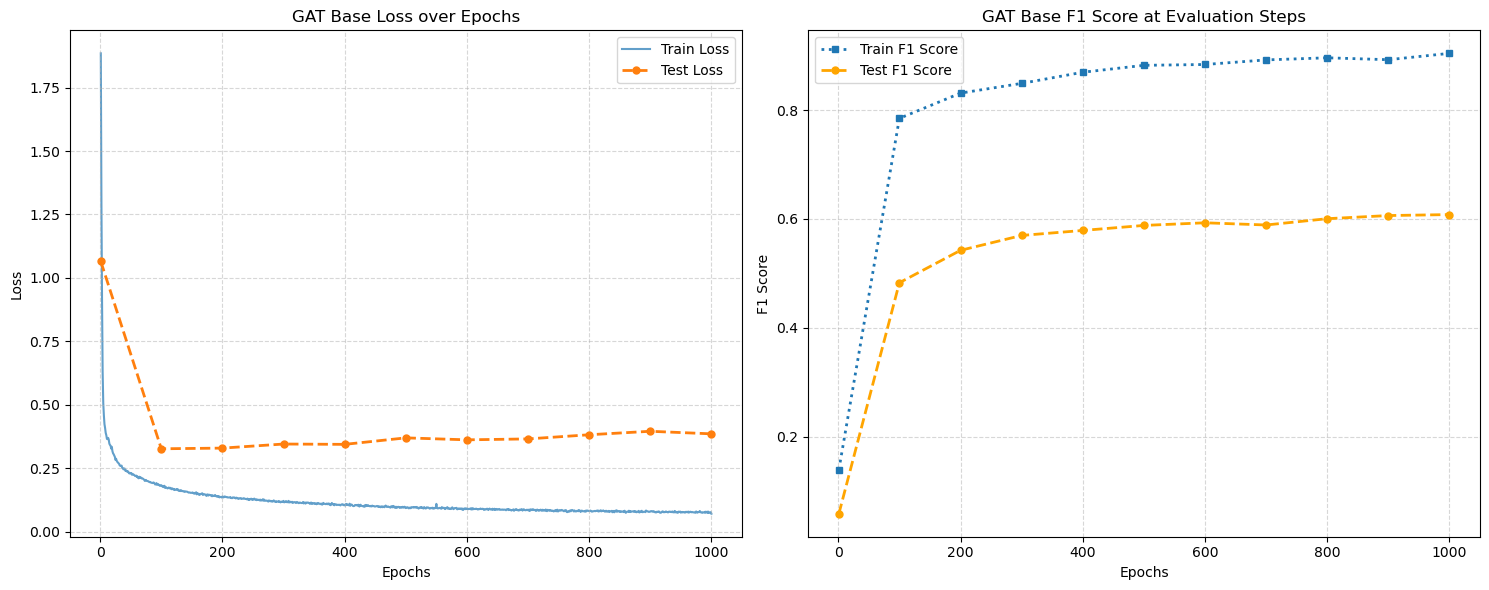

In [91]:
# base gat
gat_base = GATBase(train_feature_labeled.shape[1], embedding_dim, 2, num_heads=8, dropout=0.1).to(device)
gat_base_optimizer = torch.optim.Adam(gat_base.parameters(), lr=1e-3, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss(weight=class_weights,ignore_index=-1)
history_gat_base = train_model(
    gat_base, "GAT Base", 
    gat_base_optimizer, criterion, 
    train_graph_labeled, train_feature_labeled, train_labels_labeled, train_mask_labeled,
    test_graph_labeled, test_features_labeled, test_labels_labeled, test_mask_labeled,
    num_epochs=1000, test_every=100, previous_history=None,
    print_best_report=False, show_plots=True
)

Epoch 1100: Loss 0.0731, Train F1 0.9059, Test Loss 0.4003, Test F1 0.6033
Epoch 1200: Loss 0.0760, Train F1 0.9027, Test Loss 0.3873, Test F1 0.6034
Epoch 1200: Loss 0.0760, Train F1 0.9027, Test Loss 0.3873, Test F1 0.6034
Epoch 1300: Loss 0.0707, Train F1 0.9074, Test Loss 0.4074, Test F1 0.5996
Epoch 1300: Loss 0.0707, Train F1 0.9074, Test Loss 0.4074, Test F1 0.5996
Epoch 1400: Loss 0.0702, Train F1 0.9080, Test Loss 0.4145, Test F1 0.6013
Epoch 1400: Loss 0.0702, Train F1 0.9080, Test Loss 0.4145, Test F1 0.6013
Epoch 1500: Loss 0.0694, Train F1 0.9082, Test Loss 0.4023, Test F1 0.5988
Epoch 1500: Loss 0.0694, Train F1 0.9082, Test Loss 0.4023, Test F1 0.5988
Epoch 1600: Loss 0.0699, Train F1 0.9115, Test Loss 0.4198, Test F1 0.6002
Epoch 1600: Loss 0.0699, Train F1 0.9115, Test Loss 0.4198, Test F1 0.6002
Epoch 1700: Loss 0.0666, Train F1 0.9176, Test Loss 0.4170, Test F1 0.5965
Epoch 1700: Loss 0.0666, Train F1 0.9176, Test Loss 0.4170, Test F1 0.5965
Epoch 1800: Loss 0.0662, 

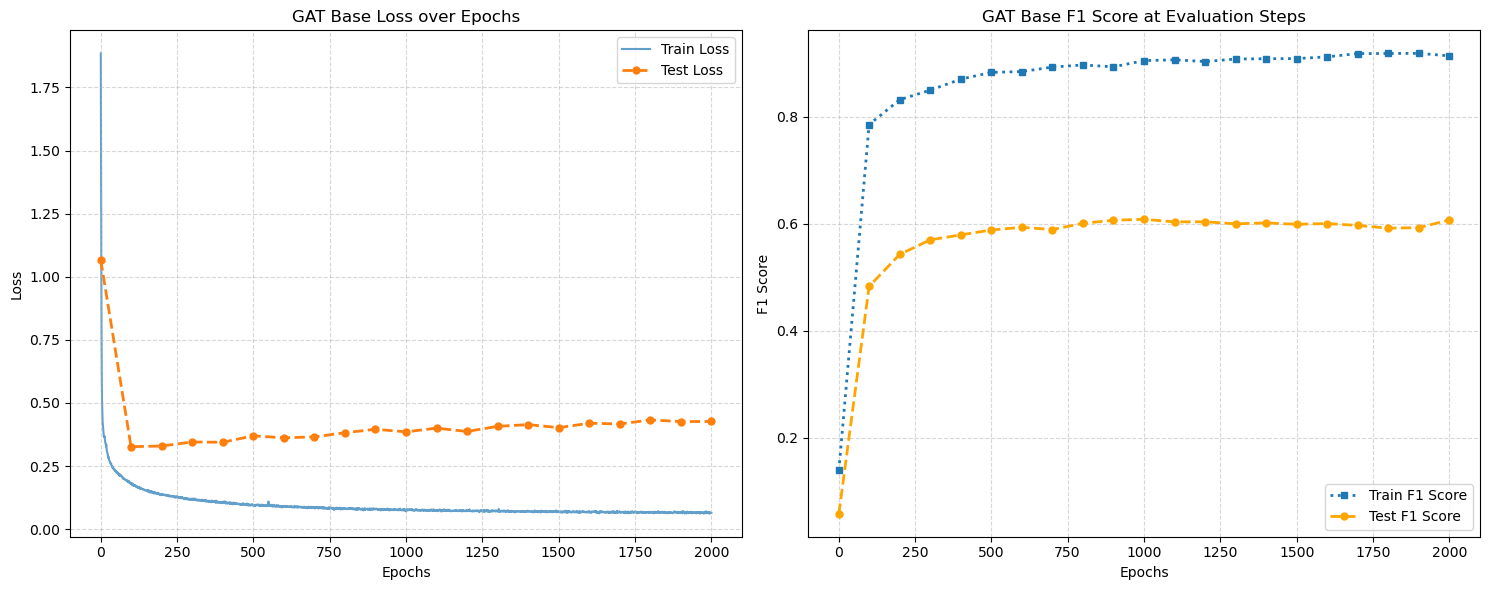

In [92]:
history_gat_base = train_model(
    gat_base, "GAT Base", 
    gat_base_optimizer, criterion, 
    train_graph_labeled, train_feature_labeled, train_labels_labeled, train_mask_labeled,
    test_graph_labeled, test_features_labeled, test_labels_labeled, test_mask_labeled,
    num_epochs=1000, test_every=100, previous_history=history_gat_base,
    print_best_report=False, show_plots=True
)

In [108]:
save_history(history_gat_base, sub_dir = "GAT_base_no_unknown")

Saved:
 - History JSON: checkpoints\GAT_base_no_unknown\history.json
 - Best state: checkpoints\GAT_base_no_unknown\best_model_state.pt
 - Latest state: checkpoints\GAT_base_no_unknown\latest_model_state.pt


In [109]:
history_gat_base = load_history(sub_dir = "GAT_base_no_unknown")

Loaded history from checkpoints\GAT_base_no_unknown


Epoch 001: Loss 0.7470, Train F1 0.1971, Test Loss 0.7518, Test F1 0.1413
Epoch 100: Loss 0.1016, Train F1 0.8903, Test Loss 0.2965, Test F1 0.5699
Epoch 200: Loss 0.0711, Train F1 0.9162, Test Loss 0.2808, Test F1 0.5955
Epoch 300: Loss 0.0599, Train F1 0.9267, Test Loss 0.2861, Test F1 0.6219
Epoch 400: Loss 0.0497, Train F1 0.9431, Test Loss 0.3006, Test F1 0.6336
Epoch 500: Loss 0.0457, Train F1 0.9425, Test Loss 0.3278, Test F1 0.6485
Epoch 600: Loss 0.0416, Train F1 0.9494, Test Loss 0.3452, Test F1 0.6414
Epoch 700: Loss 0.0402, Train F1 0.9532, Test Loss 0.3520, Test F1 0.6512
Epoch 800: Loss 0.0358, Train F1 0.9562, Test Loss 0.3751, Test F1 0.6526
Epoch 900: Loss 0.0339, Train F1 0.9545, Test Loss 0.3911, Test F1 0.6458
Epoch 1000: Loss 0.0356, Train F1 0.9525, Test Loss 0.3977, Test F1 0.6565
GAT with MLP Classifier Last Classification Report on Labeled Test Graph:
              precision    recall  f1-score   support

     illicit       0.70      0.62      0.66      1083
  

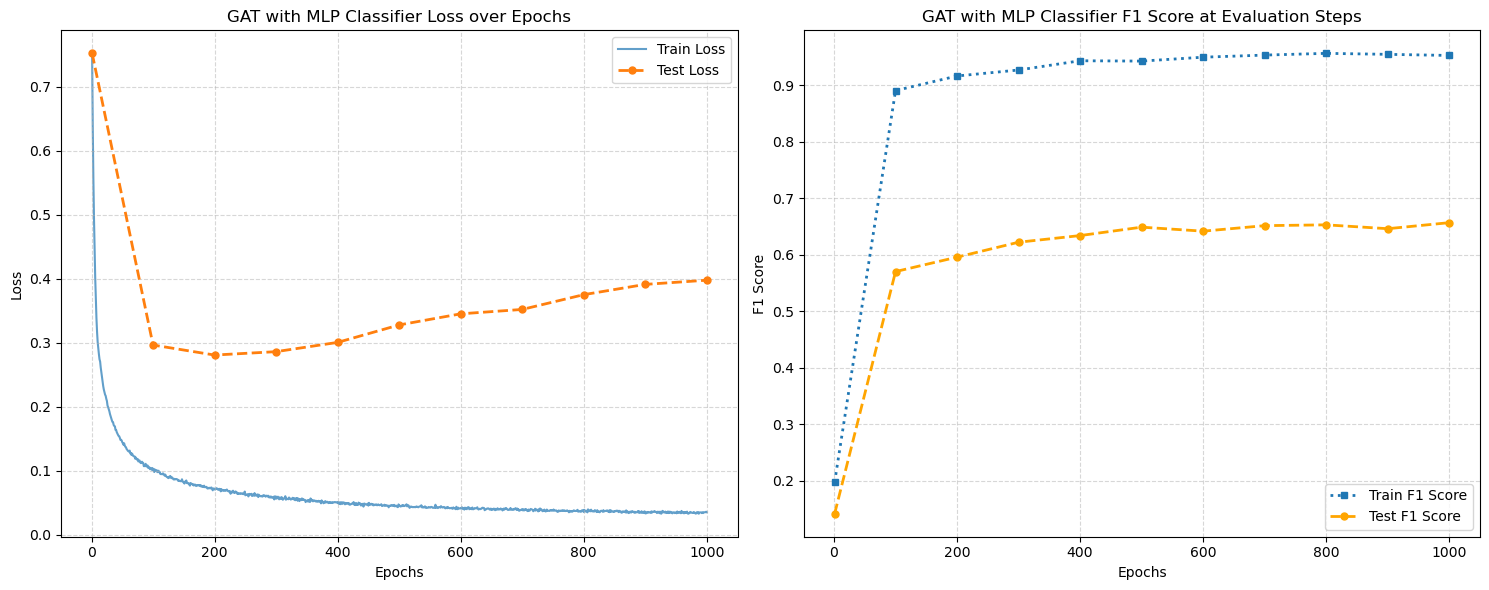

In [73]:
# 2 layer and mlp
gat_model_mlp = GATwMLP(train_features.shape[1], embedding_dim, 2, num_heads=8, dropout=0.1).to(device)
gat_model_mlp_optimizer = torch.optim.Adam(gat_model_mlp.parameters(), lr=1e-3, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss(weight=class_weights,ignore_index=-1)
history_gat_model_mlp = train_model(
    gat_model_mlp, "GAT with MLP Classifier", 
    gat_model_mlp_optimizer, criterion, 
    train_graph, train_features, train_labels, train_mask,
    test_graph, test_features, test_labels, test_mask,
    num_epochs=1000, test_every=100, previous_history=None,
    print_best_report=False, show_plots=True
)


In [110]:
save_history(history_gat_model_mlp, sub_dir="GAT_w_MLP_no_unknown")

Saved:
 - History JSON: checkpoints\GAT_w_MLP_no_unknown\history.json
 - Best state: checkpoints\GAT_w_MLP_no_unknown\best_model_state.pt
 - Latest state: checkpoints\GAT_w_MLP_no_unknown\latest_model_state.pt


In [ ]:
history_gat_model_mlp = load_history(sub_dir="GAT_w_MLP_no_unknown")

Epoch 001: Loss 0.6371, Train F1 0.0894, Test Loss 0.5889, Test F1 0.2553
Epoch 100: Loss 0.0781, Train F1 0.9135, Test Loss 0.3010, Test F1 0.5713
Epoch 200: Loss 0.0477, Train F1 0.9469, Test Loss 0.3316, Test F1 0.5667
Epoch 300: Loss 0.0349, Train F1 0.9587, Test Loss 0.3424, Test F1 0.5773
Epoch 400: Loss 0.0286, Train F1 0.9693, Test Loss 0.3422, Test F1 0.6185
Epoch 500: Loss 0.0253, Train F1 0.9716, Test Loss 0.3477, Test F1 0.6416
Epoch 600: Loss 0.0254, Train F1 0.9654, Test Loss 0.3516, Test F1 0.6466
Epoch 700: Loss 0.0207, Train F1 0.9800, Test Loss 0.3597, Test F1 0.6624
Epoch 800: Loss 0.0197, Train F1 0.9766, Test Loss 0.3929, Test F1 0.6490
Epoch 900: Loss 0.0171, Train F1 0.9846, Test Loss 0.3815, Test F1 0.6791
Epoch 1000: Loss 0.0182, Train F1 0.9796, Test Loss 0.3988, Test F1 0.6771
GAT Base Last Classification Report on Labeled Test Graph:
              precision    recall  f1-score   support

     illicit       0.86      0.56      0.68      1083
       licit     

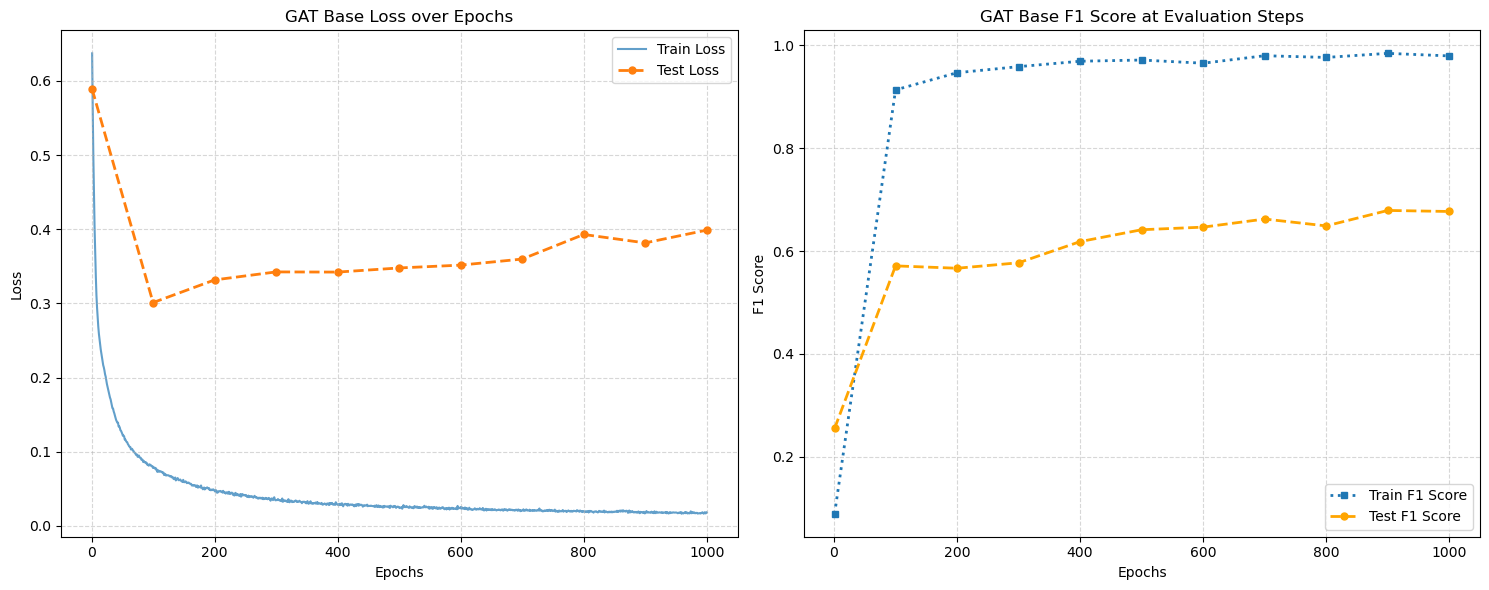

In [ ]:
# 2 layer and mlp
gat_mlp_2layer = GATwMLPDynamic(train_features.shape[1], embedding_dim, 2, num_heads=8, num_layers=2, dropout=0.1)
gat_mlp_2layer_optimizer = torch.optim.Adam(gat_mlp_2layer.parameters(), lr=1e-3, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss(weight=class_weights,ignore_index=-1)
history_gat_mlp_2layer = train_model(
    gat_mlp_2layer, "GAT MLP 2 Layer with residual", 
    gat_mlp_2layer_optimizer, criterion, 
    train_graph_labeled, train_feature_labeled, train_labels_labeled, train_mask_labeled,
    test_graph_labeled, test_features_labeled, test_labels_labeled, test_mask_labeled,
    num_epochs=1000, test_every=100, previous_history=None,
    print_best_report=False, show_plots=True
)

In [111]:
save_history(history_gat_mlp_2layer, sub_dir = "GAT_MLP_2layer_residual_no_unknown")

Saved:
 - History JSON: checkpoints\GAT_MLP_2layer_residual_no_unknown\history.json
 - Best state: checkpoints\GAT_MLP_2layer_residual_no_unknown\best_model_state.pt
 - Latest state: checkpoints\GAT_MLP_2layer_residual_no_unknown\latest_model_state.pt


In [ ]:
history_gat_mlp_2layer = load_history(sub_dir = "GAT_MLP_2layer_residual_no_unknown")

Epoch 001: Loss 0.6402, Train F1 0.1231, Test Loss 0.6529, Test F1 0.1998
Epoch 100: Loss 0.0782, Train F1 0.9052, Test Loss 0.2692, Test F1 0.5913
Epoch 200: Loss 0.0416, Train F1 0.9515, Test Loss 0.3209, Test F1 0.6401
Epoch 300: Loss 0.0307, Train F1 0.9644, Test Loss 0.3389, Test F1 0.6374
Epoch 400: Loss 0.0242, Train F1 0.9741, Test Loss 0.3728, Test F1 0.6597
Epoch 500: Loss 0.0221, Train F1 0.9724, Test Loss 0.3702, Test F1 0.6570
Epoch 600: Loss 0.0187, Train F1 0.9808, Test Loss 0.3578, Test F1 0.6795
Epoch 700: Loss 0.0159, Train F1 0.9829, Test Loss 0.3739, Test F1 0.6266
Epoch 800: Loss 0.0172, Train F1 0.9805, Test Loss 0.3871, Test F1 0.6930
Epoch 900: Loss 0.0167, Train F1 0.9855, Test Loss 0.3939, Test F1 0.6739
Epoch 1000: Loss 0.0155, Train F1 0.9826, Test Loss 0.3885, Test F1 0.6856
GAT MLP 4 Layers Last Classification Report on Labeled Test Graph:
              precision    recall  f1-score   support

     illicit       0.84      0.58      0.69      1083
       li

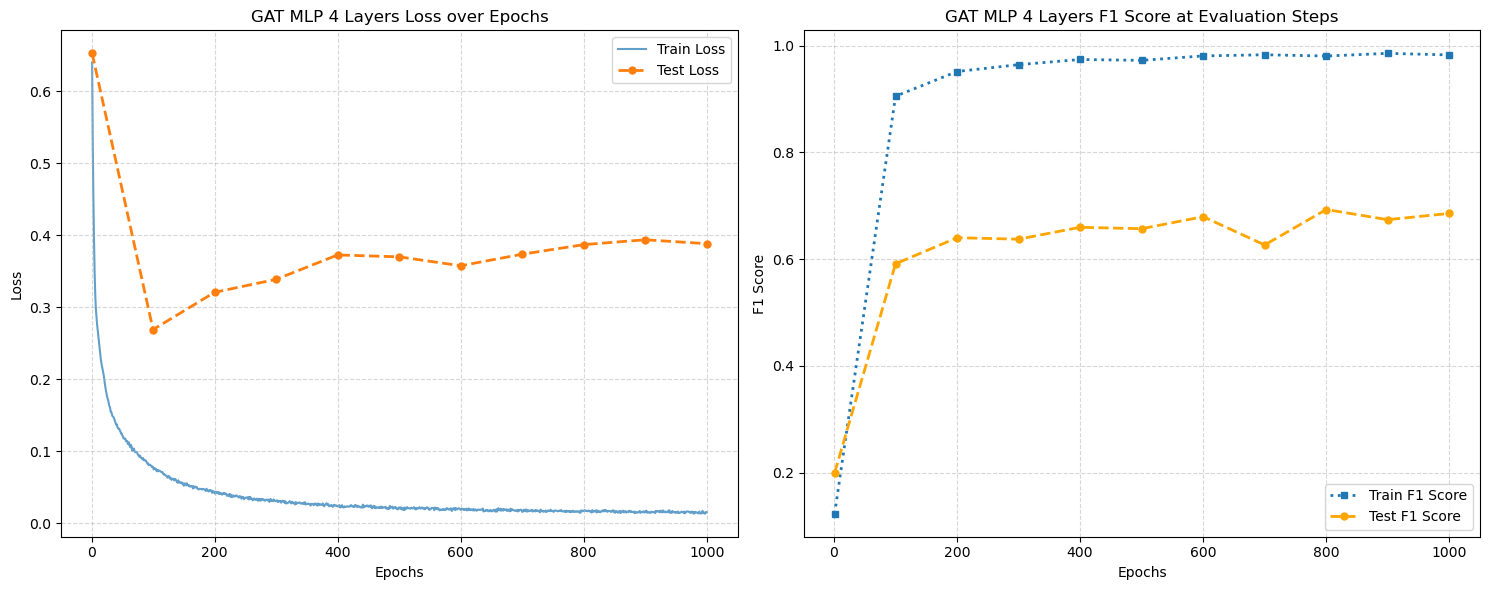

In [94]:
# 4 layer and mlp
gat_mlp_4layer = GATwMLPDynamic(train_features.shape[1], embedding_dim, 2, num_heads=8, num_layers=4, dropout=0.1)
gat_mlp_4layer_optimizer = torch.optim.Adam(gat_mlp_4layer.parameters(), lr=1e-3, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss(weight=class_weights,ignore_index=-1)
history_gat_mlp_4layer = train_model(
    gat_mlp_4layer, "GAT MLP 4 Layers", 
    gat_mlp_4layer_optimizer, criterion, 
    train_graph_labeled, train_feature_labeled, train_labels_labeled, train_mask_labeled,
    test_graph_labeled, test_features_labeled, test_labels_labeled, test_mask_labeled,
    num_epochs=1000, test_every=100, previous_history=None,
    print_best_report=False, show_plots=True
)

In [112]:
save_history(history_gat_mlp_4layer, sub_dir = "GAT_MLP_4layer_residual_no_unknown")

Saved:
 - History JSON: checkpoints\GAT_MLP_4layer_residual_no_unknown\history.json
 - Best state: checkpoints\GAT_MLP_4layer_residual_no_unknown\best_model_state.pt
 - Latest state: checkpoints\GAT_MLP_4layer_residual_no_unknown\latest_model_state.pt


In [ ]:
history_gat_mlp_4layer = load_history(sub_dir = "GAT_MLP_4layer_residual_no_unknown")

### Training - with unknown

Epoch 001: Loss 0.7385, Train F1 0.1163, Test Loss 0.6764, Test F1 0.1417
Epoch 100: Loss 0.0806, Train F1 0.9074, Test Loss 0.2503, Test F1 0.5851
Epoch 200: Loss 0.0456, Train F1 0.9505, Test Loss 0.2517, Test F1 0.6413
Epoch 300: Loss 0.0297, Train F1 0.9693, Test Loss 0.3022, Test F1 0.6275
Epoch 400: Loss 0.0224, Train F1 0.9716, Test Loss 0.3629, Test F1 0.5882
Epoch 500: Loss 0.0178, Train F1 0.9813, Test Loss 0.3898, Test F1 0.5947
Epoch 600: Loss 0.0154, Train F1 0.9830, Test Loss 0.4221, Test F1 0.5789
Epoch 700: Loss 0.0146, Train F1 0.9825, Test Loss 0.4445, Test F1 0.5687
Epoch 800: Loss 0.0132, Train F1 0.9845, Test Loss 0.4360, Test F1 0.6037
Epoch 900: Loss 0.0126, Train F1 0.9866, Test Loss 0.4568, Test F1 0.6024
Epoch 1000: Loss 0.0126, Train F1 0.9851, Test Loss 0.4600, Test F1 0.5903
GAT MLP 2 Layer with residual - with unknown Last Classification Report on Labeled Test Graph:
              precision    recall  f1-score   support

     illicit       0.68      0.52  

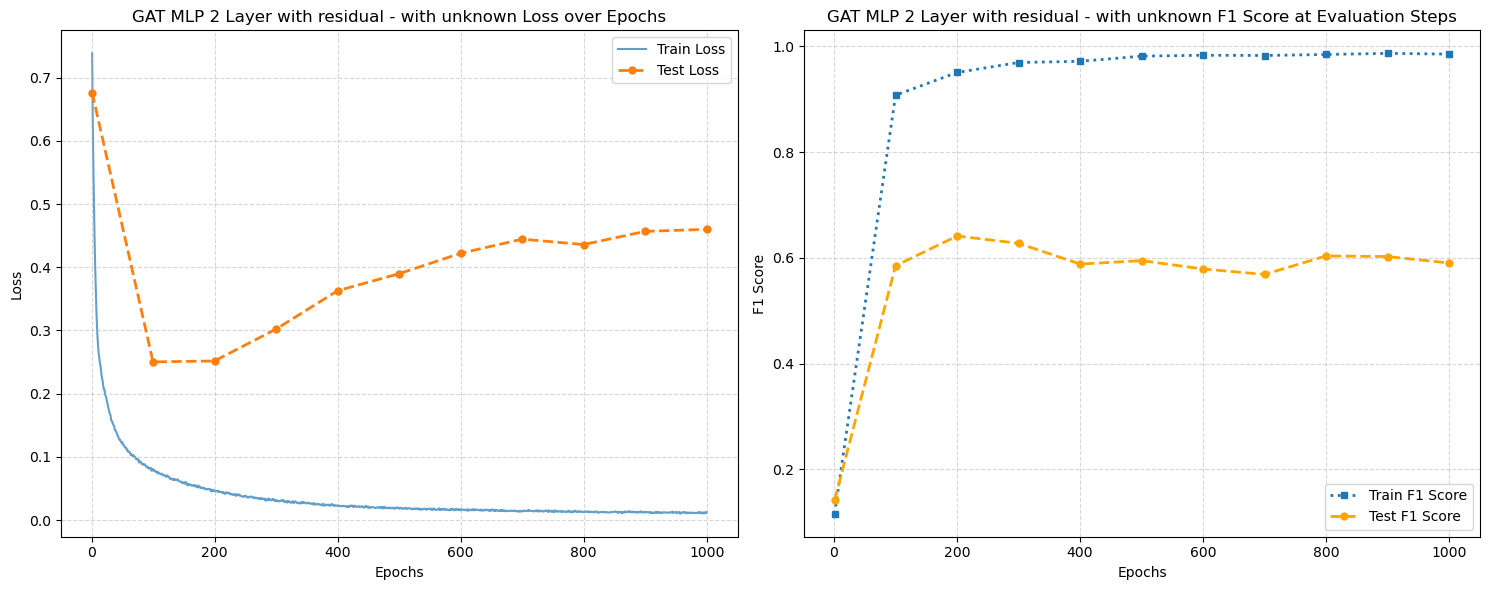

In [100]:
# 2 layer and mlp
gat_mlp_2layer_with_unknown = GATwMLPDynamic(train_features.shape[1], embedding_dim, 2, num_heads=8, num_layers=2, dropout=0.1)
gat_mlp_2layer_with_unknown_optimizer = torch.optim.Adam(gat_mlp_2layer_with_unknown.parameters(), lr=1e-3, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss(weight=class_weights,ignore_index=-1)
history_gat_mlp_2layer_with_unknown = train_model(
    gat_mlp_2layer_with_unknown, "GAT MLP 2 Layer with residual - with unknown", 
    gat_mlp_2layer_with_unknown_optimizer, criterion, 
    train_graph_all, train_feature_all, train_labels_all, train_mask_all,
    test_graph_all, test_features_all, test_labels_all, test_mask_all,
    num_epochs=1000, test_every=100, previous_history=None,
    print_best_report=False, show_plots=True
)

In [113]:
save_history(history_gat_mlp_2layer_with_unknown, sub_dir= "GAT_MLP_2layer_residual_with_unknown")

Saved:
 - History JSON: checkpoints\GAT_MLP_2layer_residual_with_unknown\history.json
 - Best state: checkpoints\GAT_MLP_2layer_residual_with_unknown\best_model_state.pt
 - Latest state: checkpoints\GAT_MLP_2layer_residual_with_unknown\latest_model_state.pt


In [ ]:
history_gat_mlp_2layer_with_unknown = load_history(sub_dir= "GAT_MLP_2layer_residual_with_unknown")

Epoch 001: Loss 0.6961, Train F1 0.2501, Test Loss 0.6149, Test F1 0.2151
Epoch 100: Loss 0.0711, Train F1 0.9120, Test Loss 0.2523, Test F1 0.6563
Epoch 200: Loss 0.0349, Train F1 0.9605, Test Loss 0.3001, Test F1 0.7007
Epoch 300: Loss 0.0226, Train F1 0.9695, Test Loss 0.3393, Test F1 0.7104
Epoch 400: Loss 0.0168, Train F1 0.9798, Test Loss 0.3787, Test F1 0.6869
Epoch 500: Loss 0.0140, Train F1 0.9842, Test Loss 0.3618, Test F1 0.6927
Epoch 600: Loss 0.0124, Train F1 0.9833, Test Loss 0.3761, Test F1 0.6939
Epoch 700: Loss 0.0116, Train F1 0.9859, Test Loss 0.4037, Test F1 0.6575
Epoch 800: Loss 0.0099, Train F1 0.9893, Test Loss 0.3915, Test F1 0.6914
Epoch 900: Loss 0.0091, Train F1 0.9892, Test Loss 0.4104, Test F1 0.6560
Epoch 1000: Loss 0.0085, Train F1 0.9912, Test Loss 0.4096, Test F1 0.7059
GAT MLP 4 Layers - with unknown Last Classification Report on Labeled Test Graph:
              precision    recall  f1-score   support

     illicit       0.86      0.60      0.71     

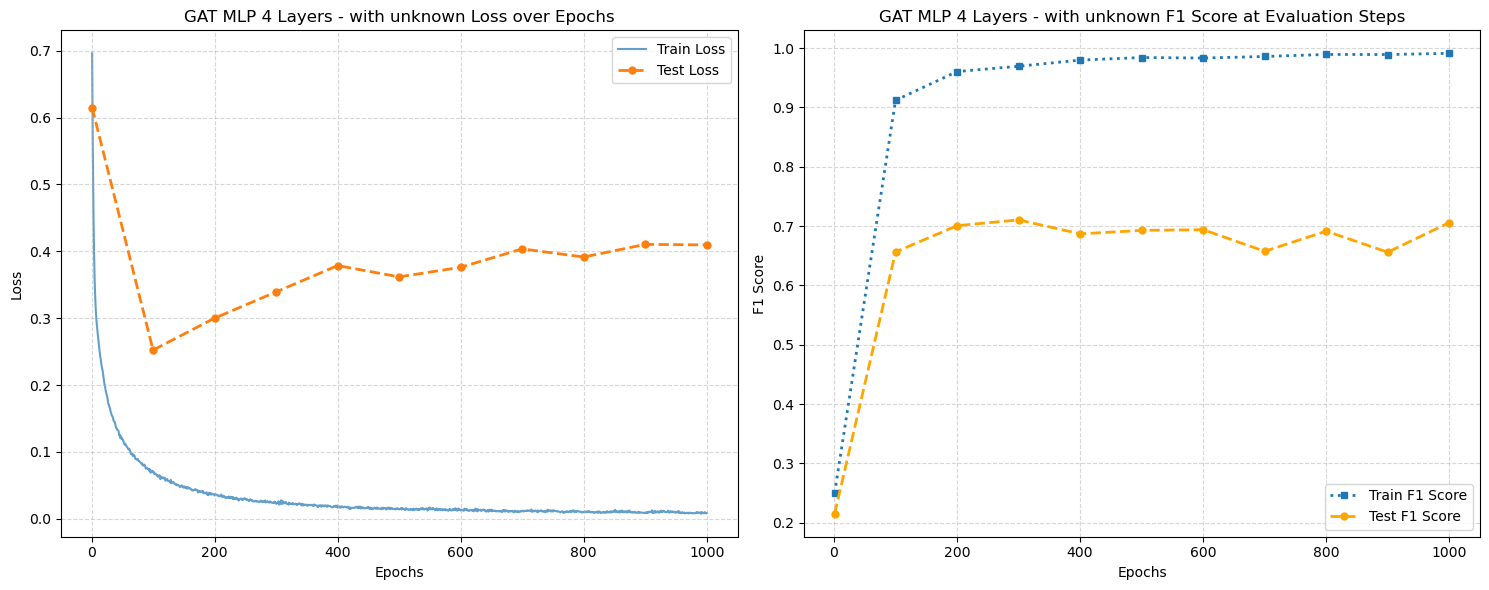

In [101]:
# 4 layer and mlp
gat_mlp_4layer_with_unknown = GATwMLPDynamic(train_features.shape[1], embedding_dim, 2, num_heads=8, num_layers=4, dropout=0.1)
gat_mlp_4layer_with_unknown_optimizer = torch.optim.Adam(gat_mlp_4layer_with_unknown.parameters(), lr=1e-3, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss(weight=class_weights,ignore_index=-1)
history_gat_mlp_4layer_with_unknown = train_model(
    gat_mlp_4layer_with_unknown, "GAT MLP 4 Layers - with unknown", 
    gat_mlp_4layer_with_unknown_optimizer, criterion, 
    train_graph_all, train_feature_all, train_labels_all, train_mask_all,
    test_graph_all, test_features_all, test_labels_all, test_mask_all,
    num_epochs=1000, test_every=100, previous_history=None,
    print_best_report=False, show_plots=True
)

In [114]:
save_history(history_gat_mlp_4layer_with_unknown, sub_dir="GAT_MLP_4layer_residual_with_unknown")

Saved:
 - History JSON: checkpoints\GAT_MLP_4layer_residual_with_unknown\history.json
 - Best state: checkpoints\GAT_MLP_4layer_residual_with_unknown\best_model_state.pt
 - Latest state: checkpoints\GAT_MLP_4layer_residual_with_unknown\latest_model_state.pt


In [ ]:
history_gat_mlp_4layer_with_unknown = load_history(sub_dir="GAT_MLP_4layer_residual_with_unknown")

## GAT v2

### Model def

In [95]:
from dgl.nn import GATv2Conv

class GATv2Base(nn.Module):
    def __init__(self, in_feats, hidden_size, out_feats, num_heads, dropout):
        super(GATv2Base, self).__init__()
        self.num_heads = num_heads

        # Check if hidden_size is divisible by num_heads
        if hidden_size % num_heads != 0:
            raise ValueError(f"hidden_size ({hidden_size}) must be divisible by num_heads ({num_heads})")
        
        head_size = hidden_size // num_heads

        self.layer1 = GATv2Conv(in_feats, head_size, num_heads, feat_drop=dropout, attn_drop=dropout, activation=F.elu, allow_zero_in_degree=True)
        self.layer2 = GATv2Conv(hidden_size, head_size, num_heads, feat_drop=dropout, attn_drop=dropout, activation=None, allow_zero_in_degree=True)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(hidden_size, out_feats)

    def forward(self, g, inputs):
        h = self.layer1(g, inputs)
        h = h.flatten(start_dim=1)
        h = self.dropout(h)
        h = self.layer2(g, h)
        h = h.flatten(start_dim=1)
        h = self.dropout(h)
        h =self.classifier(h)
        return h
    
class GATv2MLP(nn.Module):
    def __init__(self, in_feats, hidden_size, out_feats, num_heads, dropout=0.1):
        super(GATv2MLP, self).__init__()
        self.num_heads = num_heads

        # Check if hidden_size is divisible by num_heads
        if hidden_size % num_heads != 0:
            raise ValueError(f"hidden_size ({hidden_size}) must be divisible by num_heads ({num_heads})")
        
        head_size = hidden_size // num_heads
        self.input_proj = nn.Linear(in_feats, hidden_size)
        self.layer1 = GATv2Conv(hidden_size, head_size, num_heads, feat_drop=dropout, attn_drop=dropout, activation=F.elu, allow_zero_in_degree=True)
        self.norm1 = nn.LayerNorm(hidden_size)
        self.layer2 = GATv2Conv(hidden_size, head_size, num_heads, feat_drop=dropout, attn_drop=dropout, activation=F.elu, allow_zero_in_degree=True)
        self.norm2 = nn.LayerNorm(hidden_size)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, out_feats)
        )
        self.dropout = nn.Dropout(dropout)
        

    def forward(self, g, inputs):
        h = self.input_proj(inputs)
        h = self.layer1(g, h)
        h = self.norm1(h.flatten(start_dim=1))
        h = self.dropout(h)
        h = self.layer2(g, h)
        h = self.norm2(h.flatten(start_dim=1))
        h = self.dropout(h)
        h = self.classifier(h)
        return h

In [96]:
class GATv2wMLPDynamic(nn.Module):
    def __init__(self, in_feats, hidden_size, out_feats, num_heads, num_layers=2, dropout=0.1):
        super(GATv2wMLPDynamic, self).__init__()
        self.num_heads = num_heads
        self.num_layers = num_layers

        # Check if hidden_size is divisible by num_heads
        if hidden_size % num_heads != 0:
            raise ValueError(f"hidden_size ({hidden_size}) must be divisible by num_heads ({num_heads})")
        
        head_size = hidden_size // num_heads
        
        # Input projection layer
        self.input_proj = nn.Linear(in_feats, hidden_size)
        
        # Dynamic GAT layers and normalization layers
        self.gat_layers = nn.ModuleList()
        self.norm_layers = nn.ModuleList()
        
        for i in range(num_layers):
            # First layer: input is hidden_size, output is head_size per head
            # Subsequent layers: input is hidden_size (from previous layer concat), output is head_size per head
            gat_layer = GATv2Conv(
                in_feats=hidden_size,
                out_feats=head_size, 
                num_heads=num_heads, 
                feat_drop=dropout, 
                attn_drop=dropout, 
                activation=F.elu if i < num_layers - 1 else None,  # No activation on last layer
                allow_zero_in_degree=True
            )
            norm_layer = nn.LayerNorm(hidden_size)
            
            self.gat_layers.append(gat_layer)
            self.norm_layers.append(norm_layer)
        
        # Final classifier
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, out_feats)
        )
        
        self.dropout = nn.Dropout(dropout)

    def forward(self, g, inputs):
        # Input projection
        h = self.input_proj(inputs)
        
        # Apply GAT layers with residual connections and normalization
        for i, (gat_layer, norm_layer) in enumerate(zip(self.gat_layers, self.norm_layers)):
            # Store input for residual connection
            h_residual = h
            
            # Apply GAT layer
            h_new = gat_layer(g, h)
            h_new = h_new.flatten(start_dim=1)  # Flatten multi-head output
            
            # Apply residual connection + layer norm + dropout
            h = norm_layer(h_residual + self.dropout(h_new))
        
        # Final classification
        h = self.classifier(h)
        return h

# Alternative version with configurable hidden dimensions per layer
class GATv2wMLPAdvanced(nn.Module):
    def __init__(self, in_feats, hidden_sizes, out_feats, num_heads, dropout=0.1):
        """
        Args:
            in_feats: Input feature dimension
            hidden_sizes: List of hidden dimensions for each layer, e.g., [128, 128, 64]
            out_feats: Output classes
            num_heads: Number of attention heads (same for all layers)
            dropout: Dropout rate
        """
        super(GATv2wMLPAdvanced, self).__init__()
        self.num_heads = num_heads
        self.num_layers = len(hidden_sizes)

        # Check if all hidden_sizes are divisible by num_heads
        for i, hidden_size in enumerate(hidden_sizes):
            if hidden_size % num_heads != 0:
                raise ValueError(f"hidden_sizes[{i}] ({hidden_size}) must be divisible by num_heads ({num_heads})")
        
        # Input projection to first hidden size
        self.input_proj = nn.Linear(in_feats, hidden_sizes[0])
        
        # Dynamic GAT layers and normalization layers
        self.gat_layers = nn.ModuleList()
        self.norm_layers = nn.ModuleList()
        self.skip_projections = nn.ModuleList()  # For residual connections when dimensions change
        
        for i in range(self.num_layers):
            current_dim = hidden_sizes[i]
            next_dim = hidden_sizes[i + 1] if i < self.num_layers - 1 else current_dim
            head_size = next_dim // num_heads
            
            # GAT layer
            gat_layer = GATv2Conv(
                in_feats=current_dim,
                out_feats=head_size, 
                num_heads=num_heads, 
                feat_drop=dropout, 
                attn_drop=dropout, 
                activation=F.elu if i < self.num_layers - 1 else None,
                allow_zero_in_degree=True
            )
            
            # Layer normalization
            norm_layer = nn.LayerNorm(next_dim)
            
            # Skip connection projection (when dimensions change)
            if current_dim != next_dim:
                skip_proj = nn.Linear(current_dim, next_dim)
            else:
                skip_proj = nn.Identity()
            
            self.gat_layers.append(gat_layer)
            self.norm_layers.append(norm_layer)
            self.skip_projections.append(skip_proj)
        
        # Final classifier
        final_hidden_size = hidden_sizes[-1]
        self.classifier = nn.Sequential(
            nn.Linear(final_hidden_size, final_hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(final_hidden_size // 2, out_feats)
        )
        
        self.dropout = nn.Dropout(dropout)

    def forward(self, g, inputs):
        # Input projection
        h = self.input_proj(inputs)
        
        # Apply GAT layers with residual connections and normalization
        for i, (gat_layer, norm_layer, skip_proj) in enumerate(zip(self.gat_layers, self.norm_layers, self.skip_projections)):
            # Store input for residual connection
            h_residual = skip_proj(h)  # Project if dimensions change
            
            # Apply GAT layer
            h_new = gat_layer(g, h)
            h_new = h_new.flatten(start_dim=1)  # Flatten multi-head output
            
            # Apply residual connection + layer norm + dropout
            h = norm_layer(h_residual + self.dropout(h_new))
        
        # Final classification
        h = self.classifier(h)
        return h

### Training - without unknown

Epoch 001: Loss 1.2238, Train F1 0.2280, Test Loss 1.0784, Test F1 0.1488
Epoch 100: Loss 0.1585, Train F1 0.8083, Test Loss 0.3155, Test F1 0.4894
Epoch 200: Loss 0.1231, Train F1 0.8495, Test Loss 0.3387, Test F1 0.5538
Epoch 300: Loss 0.1017, Train F1 0.8772, Test Loss 0.3738, Test F1 0.5749
Epoch 400: Loss 0.0907, Train F1 0.8880, Test Loss 0.4232, Test F1 0.5821
Epoch 500: Loss 0.0850, Train F1 0.8908, Test Loss 0.4633, Test F1 0.5819
Epoch 600: Loss 0.0737, Train F1 0.9043, Test Loss 0.4857, Test F1 0.5807
Epoch 700: Loss 0.0709, Train F1 0.9109, Test Loss 0.5109, Test F1 0.5778
Epoch 800: Loss 0.0686, Train F1 0.9134, Test Loss 0.5023, Test F1 0.5762
Epoch 900: Loss 0.0657, Train F1 0.9148, Test Loss 0.4965, Test F1 0.5701
Epoch 1000: Loss 0.0614, Train F1 0.9219, Test Loss 0.5115, Test F1 0.5740
GATv2 Basic Last Classification Report on Labeled Test Graph:
              precision    recall  f1-score   support

     illicit       0.54      0.62      0.57      1083
       licit  

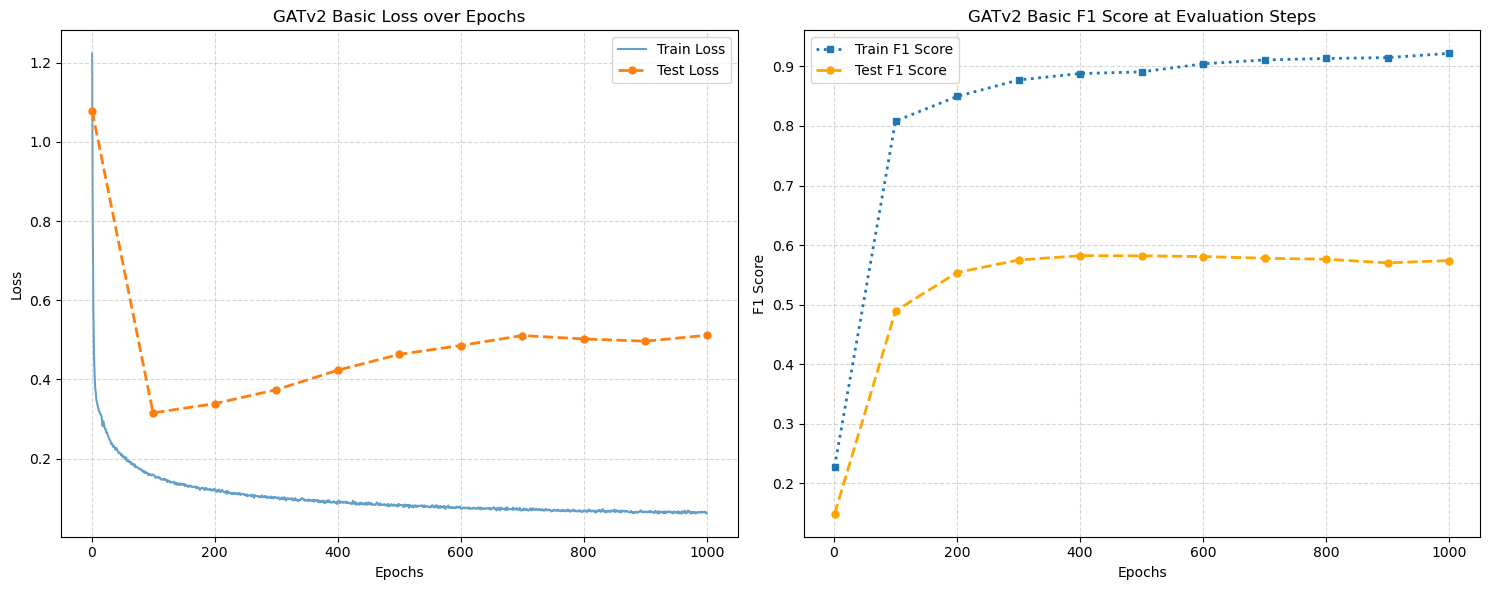

In [97]:
GATv2_base_model = GATv2Base(train_features.shape[1], embedding_dim, 2, num_heads=8, dropout=0.1).to(device)

optimizer_gatv2_base = torch.optim.Adam(GATv2_base_model.parameters(), lr=1e-3, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss(weight=class_weights,ignore_index=-1)
history_gatv2_base = train_model(
    GATv2_base_model, "GATv2 Basic", optimizer_gatv2_base, criterion, 
    train_graph, train_features, train_labels, train_mask,
    test_graph, test_features, test_labels, test_mask,
    num_epochs=1000,
    test_every=100,
    show_plots=True
)


Epoch 1100: Loss 0.0998, Train F1 0.8775, Test Loss 0.3048, Test F1 0.5864
Epoch 1200: Loss 0.0991, Train F1 0.8801, Test Loss 0.3086, Test F1 0.5867
Epoch 1300: Loss 0.0982, Train F1 0.8825, Test Loss 0.3057, Test F1 0.5868
Epoch 1400: Loss 0.0980, Train F1 0.8820, Test Loss 0.3104, Test F1 0.5891
Epoch 1500: Loss 0.0910, Train F1 0.8870, Test Loss 0.3058, Test F1 0.5911
Epoch 1600: Loss 0.0908, Train F1 0.8844, Test Loss 0.3036, Test F1 0.5862
Epoch 1700: Loss 0.0918, Train F1 0.8883, Test Loss 0.3127, Test F1 0.5861
Epoch 1800: Loss 0.0936, Train F1 0.8883, Test Loss 0.3183, Test F1 0.5862
Epoch 1900: Loss 0.0878, Train F1 0.8911, Test Loss 0.3203, Test F1 0.5855
Epoch 2000: Loss 0.0883, Train F1 0.8906, Test Loss 0.3128, Test F1 0.5845
GATv2 Basic Last Classification Report on Labeled Test Graph:
              precision    recall  f1-score   support

     illicit       0.52      0.66      0.58      1083
       licit       0.98      0.96      0.97     15587

    accuracy            

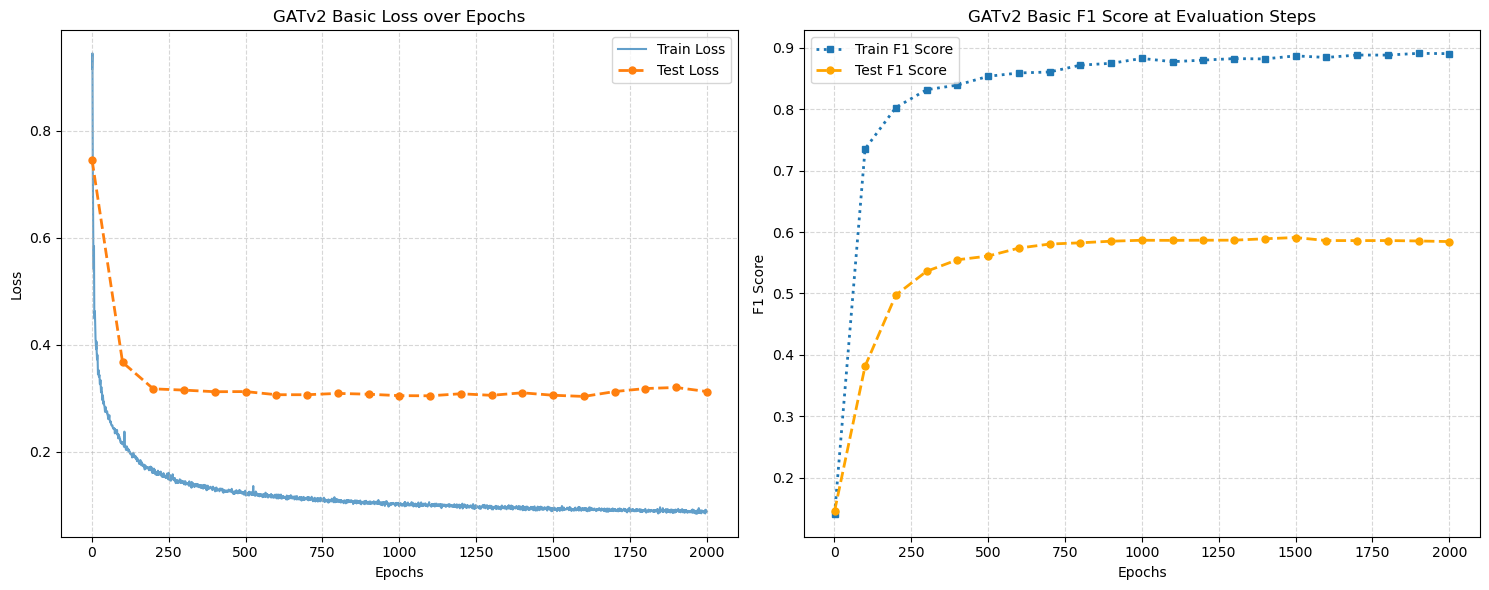

In [56]:
history_gatv2_base = train_model(
    GATv2_base_model, "GATv2 Basic", optimizer_gatv2_base, criterion, 
    train_graph, train_features, train_labels, train_mask,
    test_graph, test_features, test_labels, test_mask,
    num_epochs=1000,
    test_every=100,
    previous_history=history_gatv2_base,
    show_plots=True
)

In [115]:
save_history(history_gatv2_base, sub_dir="GATv2_base_no_unknown")

Saved:
 - History JSON: checkpoints\GATv2_base_no_unknown\history.json
 - Best state: checkpoints\GATv2_base_no_unknown\best_model_state.pt
 - Latest state: checkpoints\GATv2_base_no_unknown\latest_model_state.pt


In [ ]:
history_gatv2_base = load_history(sub_dir="GATv2_base_no_unknown")

Epoch 001: Loss 0.6747, Train F1 0.1801, Test Loss 0.6513, Test F1 0.1874
Epoch 100: Loss 0.1211, Train F1 0.8627, Test Loss 0.3396, Test F1 0.5578
Epoch 200: Loss 0.0904, Train F1 0.9004, Test Loss 0.3107, Test F1 0.5912
Epoch 300: Loss 0.0760, Train F1 0.9125, Test Loss 0.2745, Test F1 0.5979
Epoch 400: Loss 0.0660, Train F1 0.9255, Test Loss 0.2687, Test F1 0.6183
Epoch 500: Loss 0.0593, Train F1 0.9296, Test Loss 0.2741, Test F1 0.6725
Epoch 600: Loss 0.0572, Train F1 0.9348, Test Loss 0.2726, Test F1 0.6848
Epoch 700: Loss 0.0534, Train F1 0.9356, Test Loss 0.2817, Test F1 0.6650
Epoch 800: Loss 0.0503, Train F1 0.9418, Test Loss 0.2820, Test F1 0.6670
Epoch 900: Loss 0.0492, Train F1 0.9429, Test Loss 0.3021, Test F1 0.6748
Epoch 1000: Loss 0.0460, Train F1 0.9493, Test Loss 0.3066, Test F1 0.6726
GATv2 MLP Last Classification Report on Labeled Test Graph:
              precision    recall  f1-score   support

     illicit       0.72      0.63      0.67      1083
       licit    

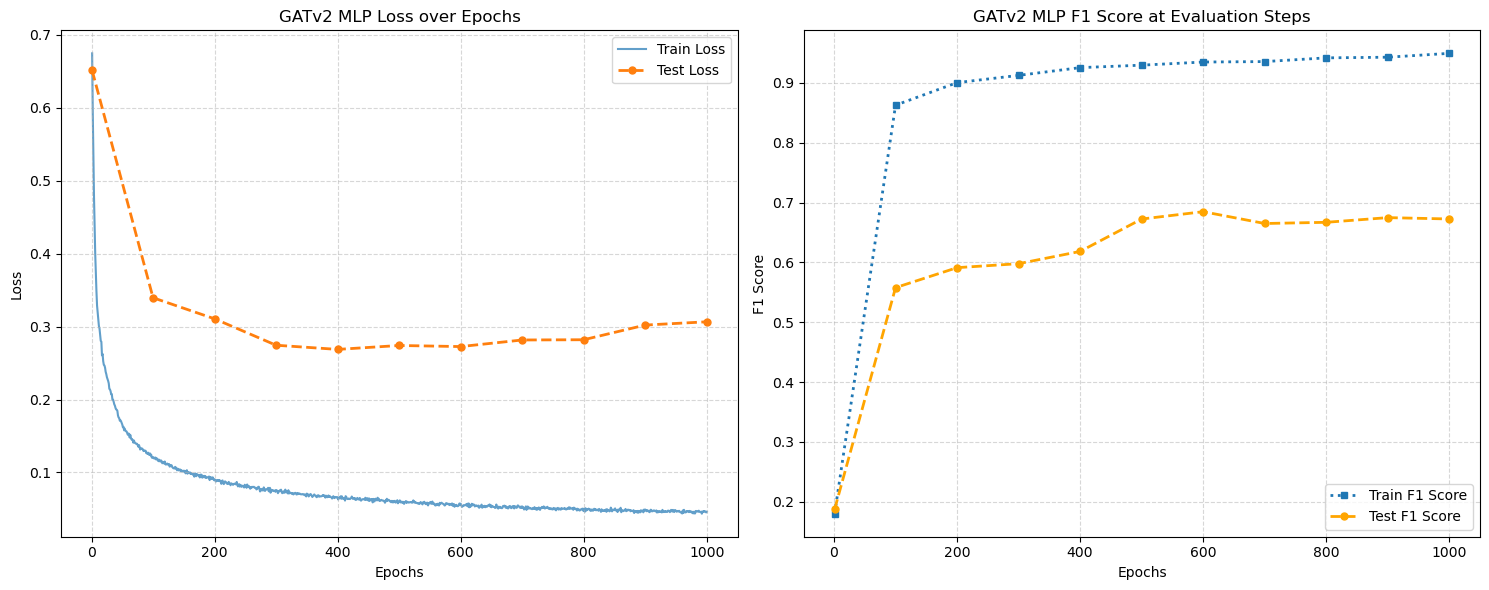

In [ ]:
# gat v2 mlp
GATv2_mlp_model = GATv2MLP(train_features.shape[1], embedding_dim, 2, num_heads=8, dropout=0.1).to(device)
optimizer_gatv2_mlp = torch.optim.Adam(GATv2_mlp_model.parameters(), lr=1e-3, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss(weight=class_weights,ignore_index=-1)
history_gatv2_mlp = train_model(
    GATv2_mlp_model, "GATv2 MLP", optimizer_gatv2_mlp, criterion, 
    train_graph, train_features, train_labels, train_mask,
    test_graph, test_features, test_labels, test_mask,
    num_epochs=1000,
    test_every=100,
    show_plots=True
)

In [116]:
save_history(history_gatv2_mlp, sub_dir="GATv2_MLP_no_unknown")

Saved:
 - History JSON: checkpoints\GATv2_MLP_no_unknown\history.json
 - Best state: checkpoints\GATv2_MLP_no_unknown\best_model_state.pt
 - Latest state: checkpoints\GATv2_MLP_no_unknown\latest_model_state.pt


In [ ]:
history_gatv2_mlp = load_history(sub_dir="GATv2_MLP_no_unknown")

Epoch 001: Loss 0.7234, Train F1 0.2014, Test Loss 0.7026, Test F1 0.1703
Epoch 100: Loss 0.0808, Train F1 0.9142, Test Loss 0.2798, Test F1 0.5659
Epoch 200: Loss 0.0506, Train F1 0.9451, Test Loss 0.3024, Test F1 0.5820
Epoch 300: Loss 0.0374, Train F1 0.9584, Test Loss 0.3206, Test F1 0.5979
Epoch 400: Loss 0.0318, Train F1 0.9680, Test Loss 0.3228, Test F1 0.6569
Epoch 500: Loss 0.0289, Train F1 0.9716, Test Loss 0.3391, Test F1 0.6472
Epoch 600: Loss 0.0241, Train F1 0.9735, Test Loss 0.3381, Test F1 0.6925
Epoch 700: Loss 0.0224, Train F1 0.9758, Test Loss 0.3514, Test F1 0.6825
Epoch 800: Loss 0.0214, Train F1 0.9755, Test Loss 0.3799, Test F1 0.6549
Epoch 900: Loss 0.0193, Train F1 0.9813, Test Loss 0.3712, Test F1 0.6795
Epoch 1000: Loss 0.0185, Train F1 0.9805, Test Loss 0.4010, Test F1 0.6823
GATv2 MLP 2 Layer with residual Last Classification Report on Labeled Test Graph:
              precision    recall  f1-score   support

     illicit       0.86      0.57      0.68     

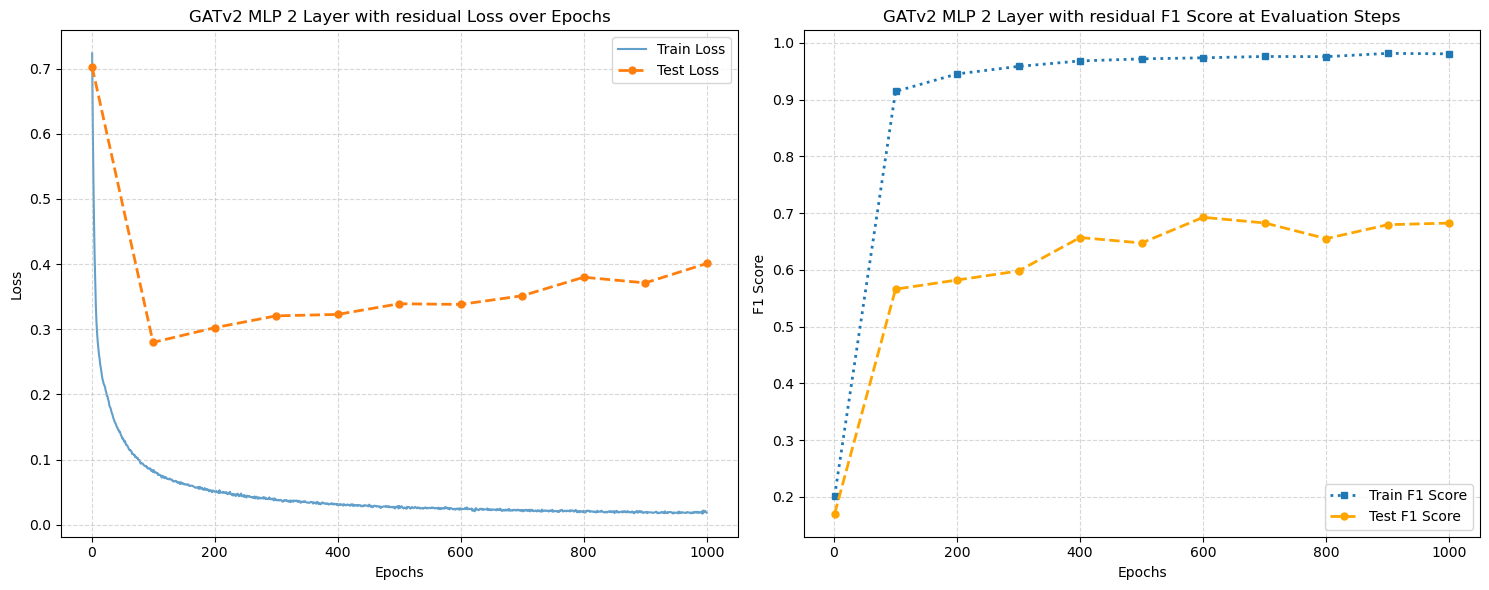

In [98]:
# 2 layer and mlp
gatv2_mlp_2layer = GATv2wMLPDynamic(train_features.shape[1], embedding_dim, 2, num_heads=8, num_layers=2, dropout=0.1)
gatv2_mlp_2layer_optimizer = torch.optim.Adam(gatv2_mlp_2layer.parameters(), lr=1e-3, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss(weight=class_weights,ignore_index=-1)
history_gatv2_mlp_2layer = train_model(
    gatv2_mlp_2layer, "GATv2 MLP 2 Layer with residual", 
    gatv2_mlp_2layer_optimizer, criterion, 
    train_graph_labeled, train_feature_labeled, train_labels_labeled, train_mask_labeled,
    test_graph_labeled, test_features_labeled, test_labels_labeled, test_mask_labeled,
    num_epochs=1000, test_every=100, previous_history=None,
    print_best_report=False, show_plots=True
)

In [117]:
save_history(history_gatv2_mlp_2layer, sub_dir = "GATv2_MLP_2layer_residual_no_unknown")

Saved:
 - History JSON: checkpoints\GATv2_MLP_2layer_residual_no_unknown\history.json
 - Best state: checkpoints\GATv2_MLP_2layer_residual_no_unknown\best_model_state.pt
 - Latest state: checkpoints\GATv2_MLP_2layer_residual_no_unknown\latest_model_state.pt


In [ ]:
load_history(sub_dir = "GATv2_MLP_2layer_residual_no_unknown")

Epoch 001: Loss 0.6822, Train F1 0.2568, Test Loss 0.6457, Test F1 0.2172
Epoch 100: Loss 0.0734, Train F1 0.9139, Test Loss 0.2967, Test F1 0.5906
Epoch 200: Loss 0.0405, Train F1 0.9549, Test Loss 0.2993, Test F1 0.6978
Epoch 300: Loss 0.0309, Train F1 0.9689, Test Loss 0.3318, Test F1 0.6997
Epoch 400: Loss 0.0247, Train F1 0.9725, Test Loss 0.3973, Test F1 0.6652
Epoch 500: Loss 0.0210, Train F1 0.9769, Test Loss 0.3910, Test F1 0.6879
Epoch 600: Loss 0.0194, Train F1 0.9785, Test Loss 0.3605, Test F1 0.7149
Epoch 700: Loss 0.0192, Train F1 0.9770, Test Loss 0.3729, Test F1 0.7130
Epoch 800: Loss 0.0167, Train F1 0.9813, Test Loss 0.4035, Test F1 0.6859
Epoch 900: Loss 0.0146, Train F1 0.9819, Test Loss 0.4264, Test F1 0.6659
Epoch 1000: Loss 0.0145, Train F1 0.9834, Test Loss 0.3984, Test F1 0.6856
GATv2 MLP 4 Layer with residual Last Classification Report on Labeled Test Graph:
              precision    recall  f1-score   support

     illicit       0.78      0.61      0.69     

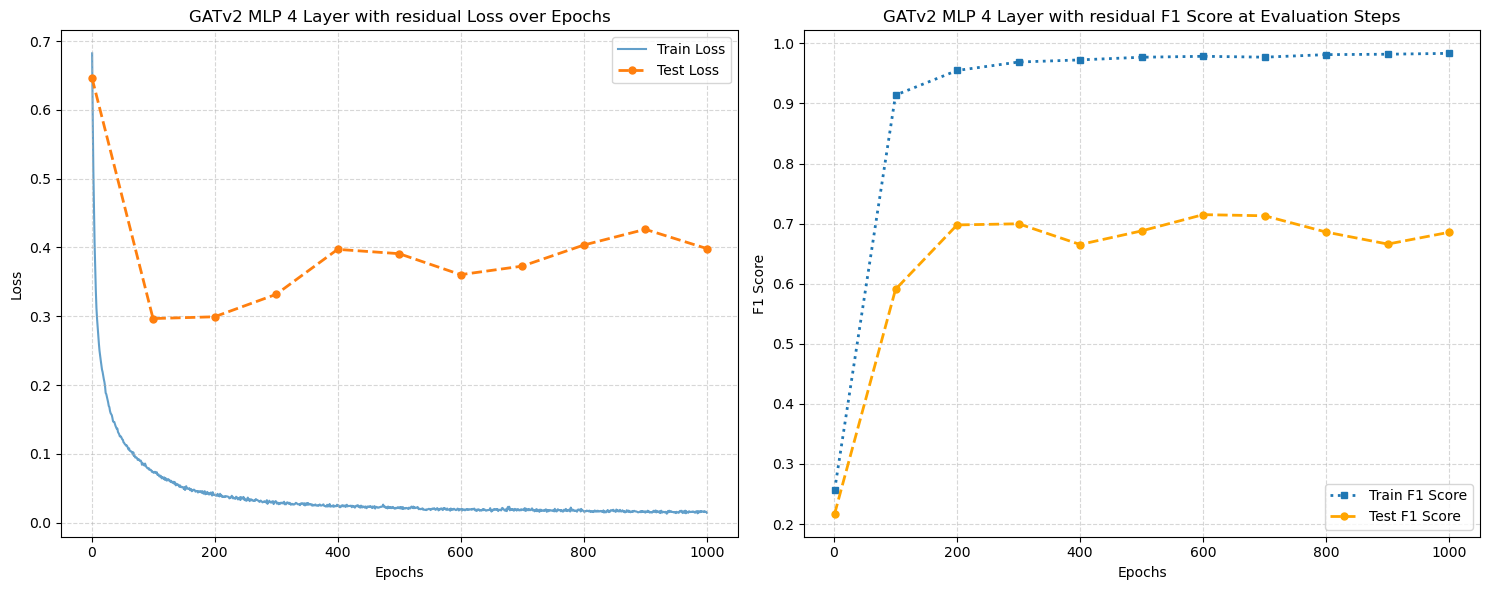

In [99]:
# 4 layer and mlp
gatv2_mlp_4layer = GATv2wMLPDynamic(train_features.shape[1], embedding_dim, 2, num_heads=8, num_layers=4, dropout=0.1)
gatv2_mlp_4layer_optimizer = torch.optim.Adam(gatv2_mlp_4layer.parameters(), lr=1e-3, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss(weight=class_weights,ignore_index=-1)
history_gatv2_mlp_4layer = train_model(
    gatv2_mlp_4layer, "GATv2 MLP 4 Layer with residual", 
    gatv2_mlp_4layer_optimizer, criterion, 
    train_graph_labeled, train_feature_labeled, train_labels_labeled, train_mask_labeled,
    test_graph_labeled, test_features_labeled, test_labels_labeled, test_mask_labeled,
    num_epochs=1000, test_every=100, previous_history=None,
    print_best_report=False, show_plots=True
)

In [118]:
save_history(history_gatv2_mlp_4layer, sub_dir="GATv2_MLP_4layer_residual_no_unknown")

Saved:
 - History JSON: checkpoints\GATv2_MLP_4layer_residual_no_unknown\history.json
 - Best state: checkpoints\GATv2_MLP_4layer_residual_no_unknown\best_model_state.pt
 - Latest state: checkpoints\GATv2_MLP_4layer_residual_no_unknown\latest_model_state.pt


In [ ]:
history_gatv2_mlp_4layer = load_history(sub_dir="GATv2_MLP_4layer_residual_no_unknown")

### Training - with unknown

Epoch 001: Loss 0.6831, Train F1 0.1536, Test Loss 0.6290, Test F1 0.2178
Epoch 100: Loss 0.0734, Train F1 0.9178, Test Loss 0.2289, Test F1 0.6186
Epoch 200: Loss 0.0401, Train F1 0.9563, Test Loss 0.2802, Test F1 0.6369
Epoch 300: Loss 0.0270, Train F1 0.9706, Test Loss 0.3063, Test F1 0.6840
Epoch 400: Loss 0.0187, Train F1 0.9808, Test Loss 0.3838, Test F1 0.6178
Epoch 500: Loss 0.0166, Train F1 0.9814, Test Loss 0.3928, Test F1 0.6327
Epoch 600: Loss 0.0129, Train F1 0.9869, Test Loss 0.4432, Test F1 0.6077
Epoch 700: Loss 0.0139, Train F1 0.9842, Test Loss 0.4450, Test F1 0.6480
Epoch 800: Loss 0.0123, Train F1 0.9855, Test Loss 0.4460, Test F1 0.6573
Epoch 900: Loss 0.0108, Train F1 0.9892, Test Loss 0.4766, Test F1 0.6257
Epoch 1000: Loss 0.0102, Train F1 0.9884, Test Loss 0.4369, Test F1 0.6840
GATv2 MLP 2 Layer with residual - with unknown Last Classification Report on Labeled Test Graph:
              precision    recall  f1-score   support

     illicit       0.85      0.57

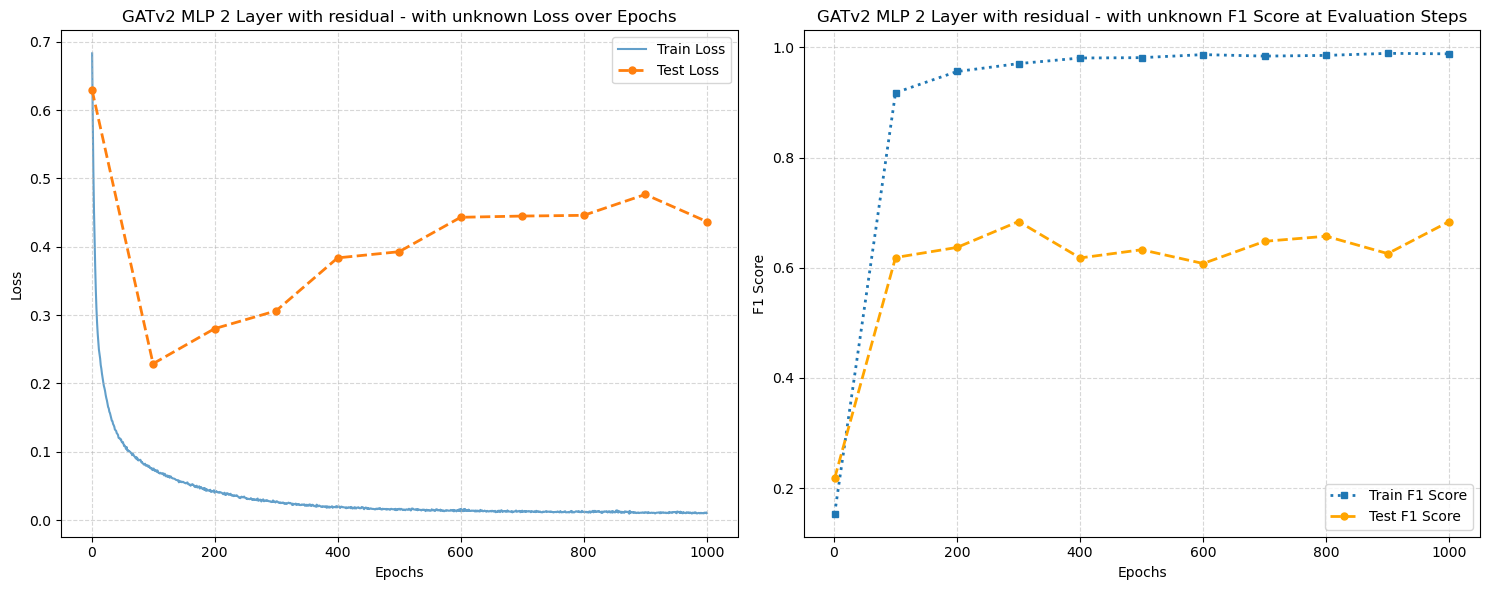

In [102]:
# 2 layer and mlp
gatv2_mlp_2layer_with_unknown = GATv2wMLPDynamic(train_features.shape[1], embedding_dim, 2, num_heads=8, num_layers=2, dropout=0.1)
gatv2_mlp_2layer_with_unknown_optimizer = torch.optim.Adam(gatv2_mlp_2layer_with_unknown.parameters(), lr=1e-3, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss(weight=class_weights,ignore_index=-1)
history_gatv2_mlp_2layer_with_unknown = train_model(
    gatv2_mlp_2layer_with_unknown, "GATv2 MLP 2 Layer with residual - with unknown", 
    gatv2_mlp_2layer_with_unknown_optimizer, criterion, 
    train_graph_all, train_feature_all, train_labels_all, train_mask_all,
    test_graph_all, test_features_all, test_labels_all, test_mask_all,
    num_epochs=1000, test_every=100, previous_history=None,
    print_best_report=False, show_plots=True
)

In [119]:
save_history(history_gatv2_mlp_2layer_with_unknown, sub_dir="GATv2_MLP_2layer_residual_with_unknown")

Saved:
 - History JSON: checkpoints\GATv2_MLP_2layer_residual_with_unknown\history.json
 - Best state: checkpoints\GATv2_MLP_2layer_residual_with_unknown\best_model_state.pt
 - Latest state: checkpoints\GATv2_MLP_2layer_residual_with_unknown\latest_model_state.pt


In [ ]:
history_gatv2_mlp_2layer_with_unknown = load_history(sub_dir="GATv2_MLP_2layer_residual_with_unknown")

In [103]:
# 4 layer and mlp
gatv2_mlp_4layer_with_unknown = GATv2wMLPDynamic(train_features.shape[1], embedding_dim, 2, num_heads=8, num_layers=4, dropout=0.1)
gatv2_mlp_4layer_with_unknown_optimizer = torch.optim.Adam(gatv2_mlp_4layer_with_unknown.parameters(), lr=1e-3, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss(weight=class_weights,ignore_index=-1)
history_gatv2_mlp_4layer_with_unknown = train_model(
    gatv2_mlp_4layer_with_unknown, "GATv2 MLP 4 Layers - with unknown", 
    gatv2_mlp_4layer_with_unknown_optimizer, criterion, 
    train_graph_all, train_feature_all, train_labels_all, train_mask_all,
    test_graph_all, test_features_all, test_labels_all, test_mask_all,
    num_epochs=1000, test_every=100, previous_history=None,
    print_best_report=False, show_plots=True
)

Epoch 001: Loss 0.7088, Train F1 0.1905, Test Loss 0.6479, Test F1 0.2166


KeyboardInterrupt: 

In [ ]:
save_history(history_gatv2_mlp_4layer_with_unknown, sub_dir="GATv2_MLP_4layer_residual_with_unknown")

In [ ]:
history_gatv2_mlp_4layer_with_unknown = load_history(sub_dir="GATv2_MLP_4layer_residual_with_unknown")

## Graph Transformer

In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import dgl.function as fn
from dgl.nn.functional import edge_softmax
from typing import Optional, Tuple, Union

class DGLTransformerConv(nn.Module):
    r"""
    DGL implementation of the PyG `TransformerConv`.
    
    This layer implements the graph transformer operator from the
    `"Masked Label Prediction: Unified Message Passing Model for 
    Semi-Supervised Classification" <https://arxiv.org/abs/2009.03509>`_ paper.
    
    Math:
        x'_i = W_1 * x_i + sum( alpha_ij * W_2 * x_j )
    
    Attention:
        alpha_ij = softmax( (W_3 * x_i)^T * (W_4 * x_j) / sqrt(d) )
    """
    def __init__(
        self,
        in_channels: Union[int, Tuple[int, int]],
        out_channels: int,
        heads: int = 1,
        concat: bool = True,
        beta: bool = False,
        dropout: float = 0.0,
        edge_dim: Optional[int] = None,
        bias: bool = True,
        root_weight: bool = True,
        allow_zero_in_degree: bool = False,
    ):
        super(DGLTransformerConv, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.heads = heads
        self.concat = concat
        self.root_weight = root_weight
        self.dropout = dropout
        self.edge_dim = edge_dim
        self.allow_zero_in_degree = allow_zero_in_degree
        self._alpha = None
        
        # Beta logic is tied to root_weight
        self.beta = beta and root_weight

        if isinstance(in_channels, int):
            in_channels = (in_channels, in_channels)

        # Linear transformations for Q, K, V
        self.lin_key = nn.Linear(in_channels[0], heads * out_channels, bias=bias)
        self.lin_query = nn.Linear(in_channels[1], heads * out_channels, bias=bias)
        self.lin_value = nn.Linear(in_channels[0], heads * out_channels, bias=bias)
        
        # Edge feature transformation
        if edge_dim is not None:
            self.lin_edge = nn.Linear(edge_dim, heads * out_channels, bias=False)
        else:
            self.register_parameter('lin_edge', None)

        # Skip connection transformation (handles concat logic)
        if concat:
            self.lin_skip = nn.Linear(in_channels[1], heads * out_channels, bias=bias)
            if self.beta:
                self.lin_beta = nn.Linear(3 * heads * out_channels, 1, bias=False)
            else:
                self.register_parameter('lin_beta', None)
        else:
            self.lin_skip = nn.Linear(in_channels[1], out_channels, bias=bias)
            if self.beta:
                self.lin_beta = nn.Linear(3 * out_channels, 1, bias=False)
            else:
                self.register_parameter('lin_beta', None)

        self.reset_parameters()

    def reset_parameters(self):
        self.lin_key.reset_parameters()
        self.lin_query.reset_parameters()
        self.lin_value.reset_parameters()
        if self.lin_edge is not None:
            self.lin_edge.reset_parameters()
        self.lin_skip.reset_parameters()
        if self.lin_beta is not None:
            self.lin_beta.reset_parameters()

    def forward(self, g, x: Union[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]], 
                edge_attr: Optional[torch.Tensor] = None,
                return_attention_weights: bool = False):
        """
        Forward pass.
        
        Args:
            g: DGL graph
            x: Node features (tensor) or tuple of (src_features, dst_features) for bipartite graphs
            edge_attr: Optional edge features
            return_attention_weights: Whether to return attention weights
            
        Returns:
            Output node features, optionally with attention weights
        """
        
        # Use a local scope to avoid modifying the input graph
        with g.local_scope():
            H, C = self.heads, self.out_channels

            # 1. Handle bipartite graphs
            if isinstance(x, tuple):
                x_src, x_dst = x
                dtype = x_dst.dtype
            else:
                x_src, x_dst = x, x
                dtype = x.dtype

            # 2. Check for zero in-degree nodes if not allowed
            if not self.allow_zero_in_degree and (g.in_degrees() == 0).any():
                raise RuntimeError("There are 0-in-degree nodes in the graph. "
                                 "Set allow_zero_in_degree=True or add self-loops.")

            # 3. Compute Q, K, V
            q_dst = self.lin_query(x_dst).view(-1, H, C)
            k_src = self.lin_key(x_src).view(-1, H, C)
            v_src = self.lin_value(x_src).view(-1, H, C)
            
            # Store in graph
            g.srcdata['k'] = k_src
            g.srcdata['v'] = v_src
            g.dstdata['q'] = q_dst

            # 4. Handle Edge Features (add to keys and values if present)
            if self.lin_edge is not None and edge_attr is not None:
                e_feat = self.lin_edge(edge_attr).view(-1, H, C)
                g.edata['e'] = e_feat
                # Add edge features to keys and values
                g.apply_edges(fn.u_add_e('k', 'e', 'k_with_edge'))
                g.apply_edges(fn.u_add_e('v', 'e', 'v_with_edge'))
                k_feat_name = 'k_with_edge'
                v_feat_name = 'v_with_edge'
            else:
                k_feat_name = 'k'
                v_feat_name = 'v'

            # 5. Compute Attention Scores (scaled dot-product: q_i^T * k_j / sqrt(d))
            def compute_attention(edges):
                # edges.src[k_feat_name]: (E, H, C), edges.dst['q']: (E, H, C)
                scores = (edges.src[k_feat_name] * edges.dst['q']).sum(dim=-1) # (E, H)
                return {'alpha': scores / math.sqrt(C)}
            
            g.apply_edges(compute_attention)
            
            # 6. Softmax and Dropout on attention weights
            g.edata['alpha'] = edge_softmax(g, g.edata['alpha'])
            
            # Store attention weights for potential return
            if return_attention_weights:
                self._alpha = g.edata['alpha'].clone()
            
            g.edata['alpha'] = F.dropout(g.edata['alpha'], p=self.dropout, training=self.training)

            # 7. Compute weighted values (alpha_ij * v_j)
            def message_func(edges):
                # edges.src[v_feat_name]: (E, H, C), edges.data['alpha']: (E, H)
                alpha_expanded = edges.data['alpha'].unsqueeze(-1)  # (E, H, 1)
                return {'msg': edges.src[v_feat_name] * alpha_expanded}  # (E, H, C)
            
            def reduce_func(nodes):
                # nodes.mailbox['msg']: (N, degree, H, C)
                return {'result': nodes.mailbox['msg'].sum(dim=1)}  # (N, H, C)
            
            # 8. Message passing
            g.update_all(message_func, reduce_func)
            
            # Get the aggregated result
            out = g.dstdata['result']  # (N_dst, H, C)

            # 9. Concatenate or average heads
            if self.concat:
                out = out.view(-1, H * C)  # (N_dst, H*C)
            else:
                out = out.mean(dim=1)      # (N_dst, C)

            # 10. Add skip connection if root_weight is True
            if self.root_weight:
                x_r = self.lin_skip(x_dst)
                
                if self.lin_beta is not None:
                    # Gating mechanism: beta * x_r + (1 - beta) * out
                    beta = self.lin_beta(torch.cat([out, x_r, out - x_r], dim=-1))
                    beta = beta.sigmoid()
                    out = beta * x_r + (1 - beta) * out
                else:
                    # Simple residual connection
                    out = out + x_r
            
            if return_attention_weights:
                return out, self._alpha
            else:
                return out
    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}({self.in_channels}, '
                f'{self.out_channels}, heads={self.heads})')

In [ ]:

class GraphTransformer(nn.Module):
    """2-layer vanilla Graph Transformer"""
    def __init__(self, input_dim, hidden_dim=128, num_classes=2, heads=8, dropout=0.1):
        super(GraphTransformer, self).__init__()
        
        # 1. First transformer layer
        self.conv1 = DGLTransformerConv(input_dim, 
                                     hidden_dim // heads, 
                                     heads=heads,
                                     dropout=dropout, # Dropout on attention weights
                                     allow_zero_in_degree=True)
        
        # 2. Second transformer layer
        self.conv2 = DGLTransformerConv(hidden_dim, 
                                     hidden_dim // heads, 
                                     heads=heads,
                                     dropout=dropout,
                                     allow_zero_in_degree=True)
        
        # Simple linear classifier
        self.classifier = nn.Linear(hidden_dim, num_classes)

    def forward(self, g, feat):
        # First transformer layer
        h = self.conv1(g, feat)
        
        # Second transformer layer  
        h = self.conv2(g, h)
        
        # Final classification
        return self.classifier(h)


class GraphTransformerMLP(nn.Module):
    """2-layer Graph Transformer with proper embedding and layer normalization"""
    def __init__(self, input_dim, hidden_dim=128, num_classes=2, heads=8, dropout=0.1):
        super(GraphTransformerMLP, self).__init__()
        
        # 1. Input embedding layer
        self.input_proj = nn.Linear(input_dim, hidden_dim)
        
        # 2. First transformer layer
        self.conv1 = DGLTransformerConv(hidden_dim, 
                                     hidden_dim // heads, 
                                     heads=heads,
                                     dropout=dropout,
                                     allow_zero_in_degree=True)
        self.norm1 = nn.LayerNorm(hidden_dim)
        
        # 3. Second transformer layer
        self.conv2 = DGLTransformerConv(hidden_dim, 
                                     hidden_dim // heads, 
                                     heads=heads,
                                     dropout=dropout,
                                     allow_zero_in_degree=True)
        self.norm2 = nn.LayerNorm(hidden_dim)
        
        # 4. Final classifier MLP
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, num_classes)
        )
        
        # 5. Dropout for the residual connections
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, g, feat):
        # Input embedding
        h = self.input_proj(feat)
        
        # First transformer block: Attention + Residual + Norm
        h_new = self.conv1(g, h)
        h = self.norm1(h + self.dropout(h_new))
        
        # Second transformer block: Attention + Residual + Norm
        h_new = self.conv2(g, h)
        h = self.norm2(h + self.dropout(h_new))
        
        # Final classification
        return self.classifier(h)

In [ ]:
embedding_dim = 128
class_weights = torch.tensor([0.7, 0.3], dtype=torch.float32, device=device)

In [ ]:
gt = GraphTransformerMLP(train_features.shape[1], embedding_dim, 2, heads=8, dropout=0.2).to(device)
optimizer = torch.optim.Adam(gt.parameters(), lr=1e-3, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss(weight=class_weights,ignore_index=-1)
history_gt_no_unknown = train_model(
    gt, "Graph Transformer (Labeled Only)", optimizer, criterion, 
    train_graph, train_features, train_labels, train_mask,
    test_graph, test_features, test_labels, test_mask,
    num_epochs=1000,
    test_every=100
)

Epoch 001: Loss 0.7506, Train F1 0.1302, Test Loss 0.6866, Test F1 0.1939
Epoch 100: Loss 0.0755, Train F1 0.9264, Test Loss 0.2368, Test F1 0.6234
Epoch 100: Loss 0.0755, Train F1 0.9264, Test Loss 0.2368, Test F1 0.6234
Epoch 200: Loss 0.0447, Train F1 0.9508, Test Loss 0.2516, Test F1 0.6580
Epoch 200: Loss 0.0447, Train F1 0.9508, Test Loss 0.2516, Test F1 0.6580
Epoch 300: Loss 0.0335, Train F1 0.9637, Test Loss 0.3054, Test F1 0.6437
Epoch 300: Loss 0.0335, Train F1 0.9637, Test Loss 0.3054, Test F1 0.6437
Epoch 400: Loss 0.0281, Train F1 0.9671, Test Loss 0.3478, Test F1 0.6429
Epoch 400: Loss 0.0281, Train F1 0.9671, Test Loss 0.3478, Test F1 0.6429
Epoch 500: Loss 0.0234, Train F1 0.9767, Test Loss 0.3477, Test F1 0.6699
Epoch 500: Loss 0.0234, Train F1 0.9767, Test Loss 0.3477, Test F1 0.6699
Epoch 600: Loss 0.0218, Train F1 0.9795, Test Loss 0.3689, Test F1 0.6732
Epoch 600: Loss 0.0218, Train F1 0.9795, Test Loss 0.3689, Test F1 0.6732
Epoch 700: Loss 0.0209, Train F1 0.981

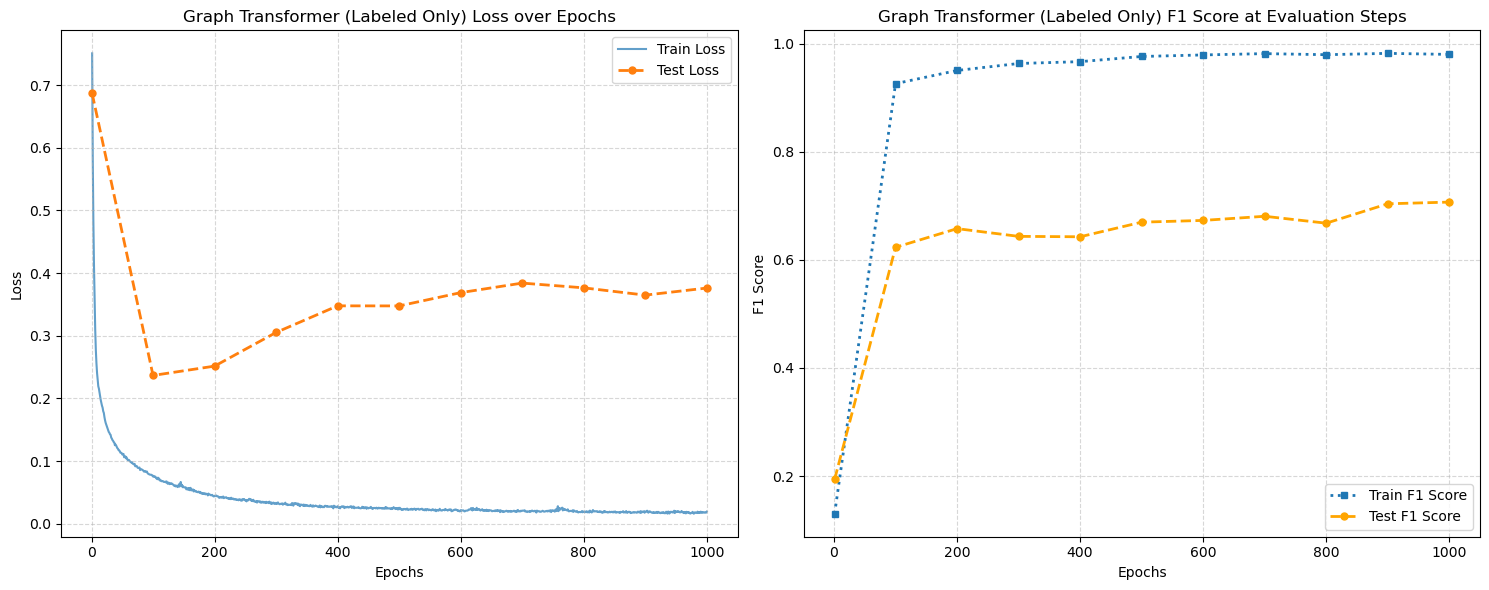

In [ ]:
plot_training_history(history_gt_no_unknown, "Graph Transformer (Labeled Only)")

In [ ]:
save_history(history_gt_no_unknown, "GT_no_unknown")

In [120]:
history_gt_no_unknown = load_history("GT_no_unknown")

Loaded history from checkpoints\GT_no_unknown
